In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from tqdm import tqdm
from collections import defaultdict
from data.utils.pdbbind import PDBbindMetadataProcessor
from data.utils.chembl_connector import ChEMBLConnector
from data.utils.enzyme_connector import ENZYMEConnector

In [2]:
figures_dir = '../hdd/pdbbind_bioactive/figures/'
sns.set_theme(style="whitegrid")
sns.set_context('talk', font_scale=1)

In [3]:
palette = sns.color_palette("colorblind")

hue_order = ['Random order',
            'Generation order',
            'MMFF94s energy',
            'SASA',
            'RGyr',
            'SchNet',
            'DimeNet++',
            'ComENet',
            'TFD2RefMCS']

hue2palette = {hue: color for hue, color in zip(hue_order, palette)}

In [44]:
clean_name_metric = {'top_score_is_bioactive_pose': 'Top score pose', 
                     'top_rmsd_is_bioactive_pose': 'Top ARMSD pose'}

clean_name_split = {'random': 'Random',
                   'scaffold': 'Scaffold'}

clean_name_ranker = {'Shuffle': 'Random order',
                    'NoRanking': 'Generation order',
                     'MMFF94s_energy': 'MMFF94s energy',
                     'ComENetModel': 'ComENet',
                     'TFD2RefMCS': 'TFD2RefMCS'
                    }

def pdbbind_analysis_for_uniprot_ids(uniprot_ids,
                                    split_types=['random', 'scaffold'],
                                     split_is=range(5),
                                    only_good_docking=True,
                                    task: str = 'all',
                                    results_dir: str = '/home/bb596/hdd/pdbbind_bioactive/results/',
                                    output_dir: str = '/home/bb596/hdd/gold_docking_pdbbind/',
                                    pose_rmsd_threshold: float = 2,
                                    conf_rmsd_threshold: float = 1,
                                    fractions = [0.01, 0.05, 0.20, 1.0],
                                    subset_name=None): #np.around(np.arange(0.01, 1.01, 0.01), 2)
    
    ranker_names = ['Shuffle', 'NoRanking', 'MMFF94s_energy',
                    # 'SchNetModel', 'DimeNetModel', 
                    'ComENetModel', 'TFD2RefMCS']
    
    subset_pdb_ids = pdbbind_df[pdbbind_df['Uniprot ID'].isin(uniprot_ids)]['PDB code'].values

    if not only_good_docking:
        
        docking_power_df = pd.DataFrame()

        for split_type in split_types:

            for split_i in split_is:

                results = []

                task_dir = os.path.join(results_dir, 
                                        f'{split_type}_split_{split_i}/', 
                                        task)

                # Load ranking results
                evaluation_name = f'{split_type}_split_{split_i}'
                evaluation_dir = os.path.join(results_dir, evaluation_name)
                ranker_name = 'ComENetModel'
                ranker_dir = os.path.join(evaluation_dir, ranker_name)
                mol_results_path = os.path.join(ranker_dir, 'ranker_mol_results.p')
                with open(mol_results_path, 'rb') as f:
                    all_mol_results = pickle.load(f)

                # Determine PDB ids to summarize
                pdb_ids = []
                for pdb_id, mol_results in tqdm(all_mol_results.items()):
                    if 'bioactive_like' in mol_results:
                        n_confs = mol_results['bioactive_like']['n_confs']
                        n_bio_like = mol_results['bioactive_like']['n_masked']
                        ratio = n_bio_like / n_confs
                        hard_condition = (ratio < 0.05) and (n_confs == 250) and (task == 'hard')
                        easy_condition = (ratio > 0.05) and (task == 'easy')
                        if hard_condition or easy_condition or task == 'all' :
                            if pdb_id in subset_pdb_ids:
                                pdb_ids.append(pdb_id)

                print('Reading files')
                for pdb_id in tqdm(pdb_ids) : 
                    result_path = os.path.join(output_dir, pdb_id, f'results_{split_type}_{split_i}.json')
                    if os.path.exists(result_path) :
                        with open(result_path, 'r') as f :
                            pdb_id_result = json.load(f)
                            pdb_id_result['pdb_id'] = pdb_id
                            results.append(pdb_id_result)
                           
                        # runtime = pdb_id_result['rigid']['runtime']
                        # if runtime > 80 and runtime < 100:
                        #     print(pdb_id, runtime)

                # import pdb;pdb.set_trace()
                            
                for metric in ['top_score_is_bioactive_pose', 'top_rmsd_is_bioactive_pose']:

                    rigid_successful_pose = {}
                    for ranker_name in ranker_names:
                        rigid_successful_pose[ranker_name] = defaultdict(list)

                    flexible_successful_pose = []
                    rigid_runtimes = []
                    flexible_runtimes = []
                    for result in results:
                        rigid_result = result['rigid']
                        rigid_runtimes.append(rigid_result['runtime'])

                        if all([ranker_name in rigid_result for ranker_name in ranker_names]):

                            for ranker_name in ranker_names:
                                ranker_result = rigid_result[ranker_name]
                                for fraction in fractions:
                                    fraction = str(fraction)
                                    fraction_result = ranker_result[fraction]
                                    rigid_successful_pose[ranker_name][fraction].append(fraction_result[metric])

                        flexible_result = result['flexible']
                        runtime = flexible_result['runtime']
                        if runtime is not None:
                            flexible_runtimes.append(runtime)
                        if metric.startswith('top_score'):
                            flexible_successful_pose.append(flexible_result['ligand_rmsd_top_score'] <= pose_rmsd_threshold)
                        else:
                            flexible_successful_pose.append(flexible_result['top_ligand_rmsd'] <= pose_rmsd_threshold)

                    rows = []
                    for ranker_name, d in rigid_successful_pose.items():
                        for fraction, l in d.items():
                            row = {}
                            row['Test set'] = clean_name_split[split_type]
                            row['Iteration'] = split_i
                            row['Ranker'] = clean_name_ranker[ranker_name]
                            row['Metric'] = clean_name_metric[metric]
                            row['Fraction'] = float(fraction)
                            row['Docking power'] = np.mean(l)
                            row['Runtime'] = np.median(rigid_runtimes) * float(fraction)
                            rows.append(row)

                    for fraction in [1]:
                        row = {}
                        row['Test set'] = clean_name_split[split_type]
                        row['Iteration'] = split_i
                        row['Ranker'] = 'Flexible'
                        row['Metric'] = clean_name_metric[metric]
                        row['Fraction'] = float(fraction)
                        row['Docking power'] = np.mean(flexible_successful_pose)
                        # import pdb;pdb.set_trace()
                        row['Runtime'] = np.median(flexible_runtimes)
                        rows.append(row)

                    docking_power_df = pd.concat([docking_power_df, pd.DataFrame(rows)])

        docking_power_df['Fraction (%)'] = docking_power_df['Fraction'].apply(lambda v: int(v * 100))
        for clean_metric in ['Top score pose', 'Top ARMSD pose']:
                    
            # decimal_fractions = np.around(np.arange(0.0, 1.1, 0.1), 2)
            fig = sns.catplot(data=docking_power_df[(docking_power_df['Metric'] == clean_metric)
                                                   &(docking_power_df['Ranker'] != 'Flexible')],
                         x='Fraction (%)',
                        y='Docking power',
                        hue='Ranker',
                        errorbar=('pi', 100),
                       kind='bar',
                       col='Test set',
                       row='Metric',
                       estimator='median',
                       errwidth=1.5,
                       capsize=0.05,
                  palette=hue2palette)
            # fig.set_titles('{col_name} {col_var}')
            fig.set_titles('')
            fig.set_ylabels(f'Successful docking rate\n({clean_metric})')
            plt.ylim(0, 1)
            test_sets = ['Random', 'Scaffold']
            for ax, test_set in zip(fig.axes[0], test_sets):
                subset_df = docking_power_df[(docking_power_df['Ranker'] == 'Flexible')
                                            &(docking_power_df['Metric'] == clean_metric)
                                            &(docking_power_df['Test set'] == test_set)]
                min_flexible = subset_df['Docking power'].min()
                max_flexible = subset_df['Docking power'].max()
                ax.axhline(min_flexible, c='silver', label='Minimum flexible docking', linestyle='--')
                ax.axhline(max_flexible, c='grey', label='Maximum flexible docking', linestyle='--')
                # ax.legend()
                
            plt.savefig(os.path.join(figures_dir, f'{clean_metric}_{subset_name}.png'))
            plt.show()
            
        fig = sns.catplot(data=docking_power_df[(docking_power_df['Ranker'] != 'Flexible')],
                         x='Fraction (%)',
                        y='Runtime',
                        errorbar=('pi', 100),
                       kind='bar',
                       col='Test set',
                       # row='Metric',
                       estimator='median',
                       errwidth=1.5,
                       capsize=0.05)
        # fig.set_titles('{col_name} {col_var}')
        fig.set_titles('')
        for ax, test_set in zip(fig.axes[0], test_sets):
            subset_df = docking_power_df[(docking_power_df['Ranker'] == 'Flexible')
                                        &(docking_power_df['Metric'] == clean_metric)
                                        &(docking_power_df['Test set'] == test_set)]
            min_flexible = subset_df['Runtime'].min()
            max_flexible = subset_df['Runtime'].max()
            ax.axhline(min_flexible, c='silver', label='Minimum flexible docking', linestyle='--')
            ax.axhline(max_flexible, c='grey', label='Maximum flexible docking', linestyle='--')
        # fig.set_ylabels(f'Runtime')
        # plt.ylim(0, 1)
        plt.savefig(os.path.join(figures_dir, f'runtimes_{subset_name}.png'))
        plt.show()
        
        df = docking_power_df
        
    else:
        
        recall_best_pose_df = pd.DataFrame()
        
        for split_type in split_types:

            for split_i in split_is:

                results = []

                task_dir = os.path.join(results_dir, 
                                        f'{split_type}_split_{split_i}/', 
                                        task)

                # Load ranking results
                evaluation_name = f'{split_type}_split_{split_i}'
                evaluation_dir = os.path.join(results_dir, evaluation_name)
                ranker_name = 'ComENetModel'
                ranker_dir = os.path.join(evaluation_dir, ranker_name)
                mol_results_path = os.path.join(ranker_dir, 'ranker_mol_results.p')
                with open(mol_results_path, 'rb') as f:
                    all_mol_results = pickle.load(f)

                # Determine PDB ids to summarize
                pdb_ids = []
                for pdb_id, mol_results in tqdm(all_mol_results.items()):
                    if 'bioactive_like' in mol_results:
                        n_confs = mol_results['bioactive_like']['n_confs']
                        n_bio_like = mol_results['bioactive_like']['n_masked']
                        ratio = n_bio_like / n_confs
                        hard_condition = (ratio < 0.05) and (n_confs == 250) and (task == 'hard')
                        easy_condition = (ratio > 0.05) and (task == 'easy')
                        if hard_condition or easy_condition or task == 'all' :
                            if pdb_id in subset_pdb_ids:
                                pdb_ids.append(pdb_id)

                print('Reading files')
                for pdb_id in tqdm(pdb_ids) : 
                    result_path = os.path.join(output_dir, pdb_id, f'results_{split_type}_{split_i}.json')
                    if os.path.exists(result_path) :
                        with open(result_path, 'r') as f :
                            results.append(json.load(f))

                metric = 'bioactive_pose_first_normalized_index'
                
                best_pose_indexes = {}
                for ranker_name in ranker_names:
                    best_pose_indexes[ranker_name] = []
                    
                for result in results:
                    rigid_result = result['rigid']

                    if all([ranker_name in rigid_result for ranker_name in ranker_names]):

                        for ranker_name in ranker_names:
                            ranker_result = rigid_result[ranker_name]
                            if metric in ranker_result:
                                best_pose_indexes[ranker_name].append(ranker_result[metric])

                rows = []
                for ranker_name, indexes in best_pose_indexes.items():
                    indexes = np.array(indexes)
                    for fraction in fractions:
                        row = {}
                        row['Test set'] = split_type
                        row['Iteration'] = split_i
                        row['Ranker'] = ranker_name
                        row['Fraction'] = fraction
                        row['Proportion'] = np.mean(indexes <= fraction)
                        rows.append(row)

                recall_best_pose_df = pd.concat([recall_best_pose_df, pd.DataFrame(rows)])
                
        sns.catplot(data=recall_best_pose_df,
                     x='Fraction',
                    y='Proportion',
                    hue='Ranker',
                    errorbar=('pi', 100),
                   kind='bar',
                   col='Test set',
                   estimator='median',
                   errwidth=1.5,
                   capsize=0.05,
                  palette=hue2palette)
        plt.ylim(0, 1)
        plt.show()
        
        df = recall_best_pose_df

    return df

In [5]:
def custom_agg(series) :
    result = ''
    
    mean = series.mean()
    if not np.isnan(mean) :
        result = result + str(mean.round(2))
        
    std = series.std().round(2)
    if not np.isnan(std) :
        result = result + ' ± ' + str(std.round(2))
    
    if result == '' :
        result = 'NA'
    return result

In [6]:
pmp = PDBbindMetadataProcessor(root='../hdd/PDBbind/', 
                               remove_unknown_ligand_name=True, 
                               remove_unknown_uniprot=True)
pdbbind_df = pmp.get_master_dataframe()

In [28]:
df[(df['Runtime'] < 100) & (df['Runtime'] > 50)]

Test set  Iteration            Ranker          Metric  Fraction  \
2     Random          0      Random order  Top score pose       0.2   
6     Random          0  Generation order  Top score pose       0.2   
10    Random          0    MMFF94s energy  Top score pose       0.2   
14    Random          0           ComENet  Top score pose       0.2   
18    Random          0        TFD2RefMCS  Top score pose       0.2   
..       ...        ...               ...             ...       ...   
2   Scaffold          4      Random order  Top ARMSD pose       0.2   
6   Scaffold          4  Generation order  Top ARMSD pose       0.2   
10  Scaffold          4    MMFF94s energy  Top ARMSD pose       0.2   
14  Scaffold          4           ComENet  Top ARMSD pose       0.2   
18  Scaffold          4        TFD2RefMCS  Top ARMSD pose       0.2   

    Docking power    Runtime  Fraction (%)  
2        0.594595  83.263629            20  
6        0.599509  83.263629            20  
10       0.624079  83.263629            20  
14       0.652334  83.263629            20  
18       0.660934  83.263629            20  
..            ...        ...           ...  
2        0.845730  81.579035            20  
6        0.815427  81.579035            20  
10       0.804408  81.579035            20  
14       0.825069  81.579035            20  
18       0.812672  81.579035            20  

[100 rows x 8 columns]

100%|█████████████████████████████████████| 1394/1394 [00:00<00:00, 7983.25it/s]


Reading files


100%|█████████████████████████████████████| 1311/1311 [00:00<00:00, 7191.14it/s]


Reading files


100%|█████████████████████████████████████| 1438/1438 [00:00<00:00, 7474.40it/s]


Reading files


100%|█████████████████████████████████████| 1352/1352 [00:00<00:00, 7477.89it/s]


Reading files


100%|█████████████████████████████████████| 1350/1350 [00:00<00:00, 7280.01it/s]


Reading files


100%|█████████████████████████████████████| 1566/1566 [00:00<00:00, 7655.62it/s]


Reading files


100%|█████████████████████████████████████| 1264/1264 [00:00<00:00, 6908.21it/s]


Reading files


100%|█████████████████████████████████████| 1204/1204 [00:00<00:00, 7198.73it/s]


Reading files


100%|█████████████████████████████████████| 1319/1319 [00:00<00:00, 8112.57it/s]


Reading files


100%|█████████████████████████████████████| 1322/1322 [00:00<00:00, 7352.82it/s]


Reading files


100%|█████████████████████████████████████████| 624/624 [00:08<00:00, 76.78it/s]


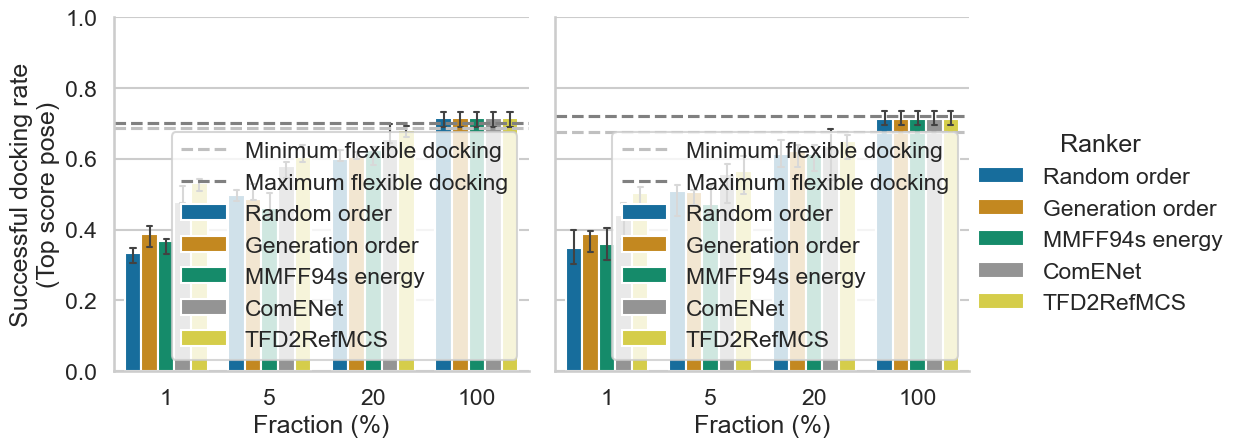

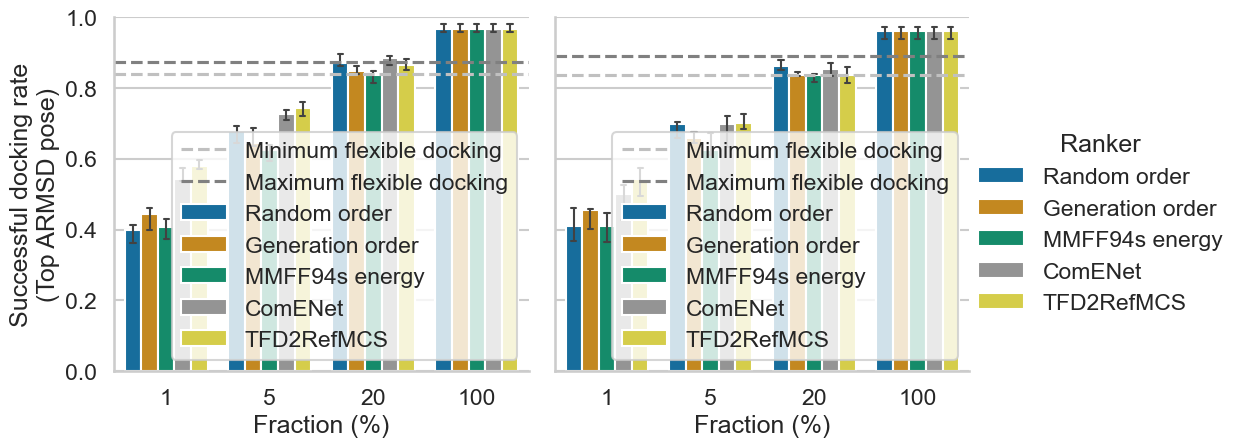

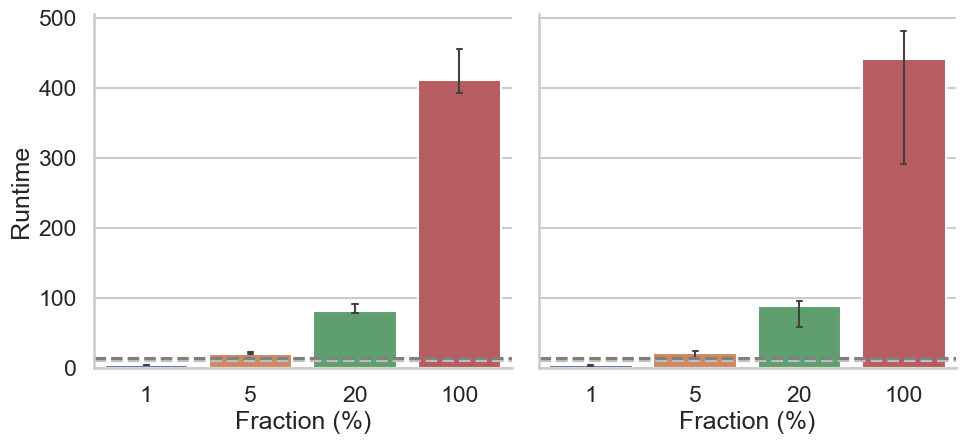

In [45]:
uniprot_ids = pdbbind_df['Uniprot ID'].values
df = pdbbind_analysis_for_uniprot_ids(uniprot_ids, 
                                      only_good_docking=False,
                                     subset_name='all')

In [14]:
df.groupby(['Test set', 'Ranker', 'Fraction', 'Metric'], 
           sort=False).agg(custom_agg).reset_index().pivot_table(index=['Test set', 'Metric', 'Fraction'], 
                                                                 columns='Ranker', 
                                                                 values='Docking power',
                                                                 aggfunc='first')

Ranker                                ComENet     Flexible Generation order  \
Test set Metric         Fraction                                              
Random   Top ARMSD pose 0.01      0.54 ± 0.02          NaN      0.44 ± 0.02   
                        0.05      0.71 ± 0.01          NaN      0.65 ± 0.02   
                        0.20      0.86 ± 0.01          NaN      0.84 ± 0.01   
                        1.00       0.96 ± 0.0  0.86 ± 0.01       0.96 ± 0.0   
         Top score pose 0.01      0.48 ± 0.02          NaN      0.39 ± 0.02   
                        0.05      0.56 ± 0.02          NaN       0.5 ± 0.02   
                        0.20      0.65 ± 0.02          NaN       0.6 ± 0.01   
                        1.00       0.7 ± 0.01  0.68 ± 0.01       0.7 ± 0.01   
Scaffold Top ARMSD pose 0.01      0.49 ± 0.03          NaN      0.44 ± 0.02   
                        0.05      0.68 ± 0.03          NaN      0.65 ± 0.01   
                        0.20      0.84 ± 0.01          NaN      0.83 ± 0.01   
                        1.00      0.95 ± 0.01  0.86 ± 0.01      0.95 ± 0.01   
         Top score pose 0.01      0.43 ± 0.03          NaN      0.38 ± 0.02   
                        0.05      0.53 ± 0.04          NaN       0.5 ± 0.01   
                        0.20      0.62 ± 0.05          NaN       0.6 ± 0.02   
                        1.00      0.69 ± 0.02  0.68 ± 0.02      0.69 ± 0.02   

Ranker                           MMFF94s energy Random order   TFD2RefMCS  
Test set Metric         Fraction                                           
Random   Top ARMSD pose 0.01         0.4 ± 0.02   0.4 ± 0.01  0.57 ± 0.01  
                        0.05        0.62 ± 0.01  0.67 ± 0.01  0.73 ± 0.01  
                        0.20        0.83 ± 0.01  0.86 ± 0.01  0.85 ± 0.01  
                        1.00         0.96 ± 0.0   0.96 ± 0.0   0.96 ± 0.0  
         Top score pose 0.01        0.36 ± 0.02  0.34 ± 0.01  0.52 ± 0.02  
                        0.05        0.47 ± 0.02  0.49 ± 0.01   0.6 ± 0.01  
                        0.20        0.61 ± 0.02   0.6 ± 0.01  0.66 ± 0.01  
                        1.00         0.7 ± 0.01   0.7 ± 0.01   0.7 ± 0.01  
Scaffold Top ARMSD pose 0.01         0.4 ± 0.03  0.41 ± 0.02  0.52 ± 0.02  
                        0.05        0.63 ± 0.02  0.68 ± 0.02  0.68 ± 0.02  
                        0.20        0.83 ± 0.02  0.86 ± 0.01  0.82 ± 0.02  
                        1.00        0.95 ± 0.01  0.95 ± 0.01  0.95 ± 0.01  
         Top score pose 0.01        0.35 ± 0.03  0.35 ± 0.03  0.48 ± 0.03  
                        0.05        0.47 ± 0.03  0.49 ± 0.03  0.55 ± 0.03  
                        0.20         0.6 ± 0.02   0.6 ± 0.02  0.62 ± 0.02  
                        1.00        0.69 ± 0.02  0.69 ± 0.02  0.69 ± 0.02

In [15]:
df.groupby(['Test set', 'Ranker', 'Fraction', 'Metric'], 
           sort=False).agg(custom_agg).reset_index().pivot_table(index=['Test set', 'Metric', 'Fraction'], 
                                                                 columns='Ranker', 
                                                                 values='Runtime',
                                                                 aggfunc='first')

Ranker                                   ComENet      Flexible  \
Test set Metric         Fraction                                 
Random   Top ARMSD pose 0.01         3.95 ± 0.27           NaN   
                        0.05        19.75 ± 1.33           NaN   
                        0.20        79.01 ± 5.33           NaN   
                        1.00      395.04 ± 26.64  13.07 ± 0.65   
         Top score pose 0.01         3.95 ± 0.27           NaN   
                        0.05        19.75 ± 1.33           NaN   
                        0.20        79.01 ± 5.33           NaN   
                        1.00      395.04 ± 26.64  13.07 ± 0.65   
Scaffold Top ARMSD pose 0.01          4.0 ± 0.65           NaN   
                        0.05        20.01 ± 3.23           NaN   
                        0.20       80.05 ± 12.93           NaN   
                        1.00      400.24 ± 64.63   13.11 ± 1.1   
         Top score pose 0.01          4.0 ± 0.65           NaN   
                        0.05        20.01 ± 3.23           NaN   
                        0.20       80.05 ± 12.93           NaN   
                        1.00      400.24 ± 64.63   13.11 ± 1.1   

Ranker                           Generation order  MMFF94s energy  \
Test set Metric         Fraction                                    
Random   Top ARMSD pose 0.01          3.95 ± 0.27     3.95 ± 0.27   
                        0.05         19.75 ± 1.33    19.75 ± 1.33   
                        0.20         79.01 ± 5.33    79.01 ± 5.33   
                        1.00       395.04 ± 26.64  395.04 ± 26.64   
         Top score pose 0.01          3.95 ± 0.27     3.95 ± 0.27   
                        0.05         19.75 ± 1.33    19.75 ± 1.33   
                        0.20         79.01 ± 5.33    79.01 ± 5.33   
                        1.00       395.04 ± 26.64  395.04 ± 26.64   
Scaffold Top ARMSD pose 0.01           4.0 ± 0.65      4.0 ± 0.65   
                        0.05         20.01 ± 3.23    20.01 ± 3.23   
                        0.20        80.05 ± 12.93   80.05 ± 12.93   
                        1.00       400.24 ± 64.63  400.24 ± 64.63   
         Top score pose 0.01           4.0 ± 0.65      4.0 ± 0.65   
                        0.05         20.01 ± 3.23    20.01 ± 3.23   
                        0.20        80.05 ± 12.93   80.05 ± 12.93   
                        1.00       400.24 ± 64.63  400.24 ± 64.63   

Ranker                              Random order      TFD2RefMCS  
Test set Metric         Fraction                                  
Random   Top ARMSD pose 0.01         3.95 ± 0.27     3.95 ± 0.27  
                        0.05        19.75 ± 1.33    19.75 ± 1.33  
                        0.20        79.01 ± 5.33    79.01 ± 5.33  
                        1.00      395.04 ± 26.64  395.04 ± 26.64  
         Top score pose 0.01         3.95 ± 0.27     3.95 ± 0.27  
                        0.05        19.75 ± 1.33    19.75 ± 1.33  
                        0.20        79.01 ± 5.33    79.01 ± 5.33  
                        1.00      395.04 ± 26.64  395.04 ± 26.64  
Scaffold Top ARMSD pose 0.01          4.0 ± 0.65      4.0 ± 0.65  
                        0.05        20.01 ± 3.23    20.01 ± 3.23  
                        0.20       80.05 ± 12.93   80.05 ± 12.93  
                        1.00      400.24 ± 64.63  400.24 ± 64.63  
         Top score pose 0.01          4.0 ± 0.65      4.0 ± 0.65  
                        0.05        20.01 ± 3.23    20.01 ± 3.23  
                        0.20       80.05 ± 12.93   80.05 ± 12.93  
                        1.00      400.24 ± 64.63  400.24 ± 64.63

100%|████████████████████████████████████| 1394/1394 [00:00<00:00, 22417.91it/s]


Reading files


100%|████████████████████████████████████| 1311/1311 [00:00<00:00, 21401.34it/s]


Reading files


100%|████████████████████████████████████| 1438/1438 [00:00<00:00, 19196.27it/s]


Reading files


100%|████████████████████████████████████| 1352/1352 [00:00<00:00, 25432.22it/s]


Reading files


100%|████████████████████████████████████| 1350/1350 [00:00<00:00, 19332.29it/s]


Reading files


100%|████████████████████████████████████| 1566/1566 [00:00<00:00, 17757.29it/s]


Reading files


100%|████████████████████████████████████| 1264/1264 [00:00<00:00, 19890.00it/s]


Reading files


100%|████████████████████████████████████| 1204/1204 [00:00<00:00, 20533.73it/s]


Reading files


100%|████████████████████████████████████| 1319/1319 [00:00<00:00, 31005.71it/s]


Reading files


100%|████████████████████████████████████| 1322/1322 [00:00<00:00, 21711.98it/s]


Reading files


100%|████████████████████████████████████████| 277/277 [00:00<00:00, 624.94it/s]


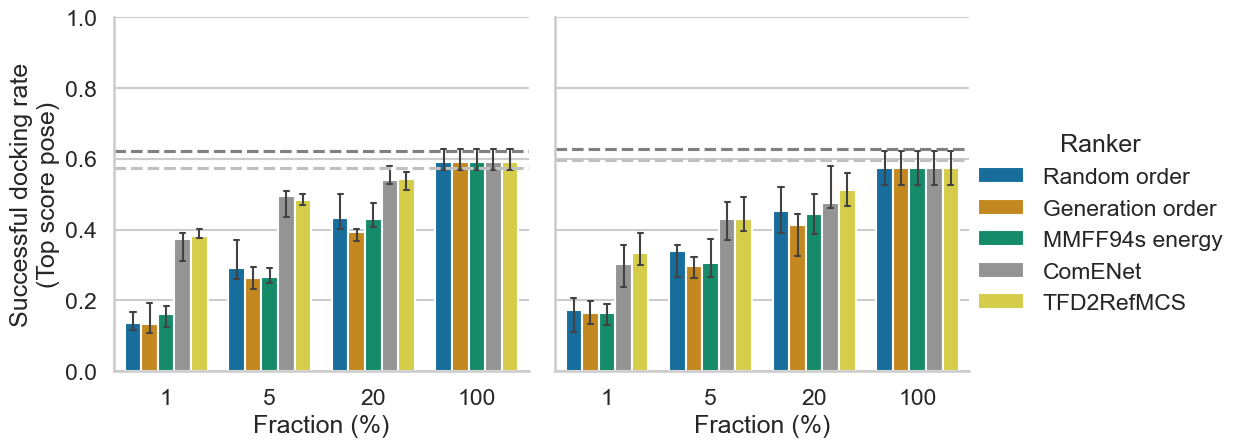

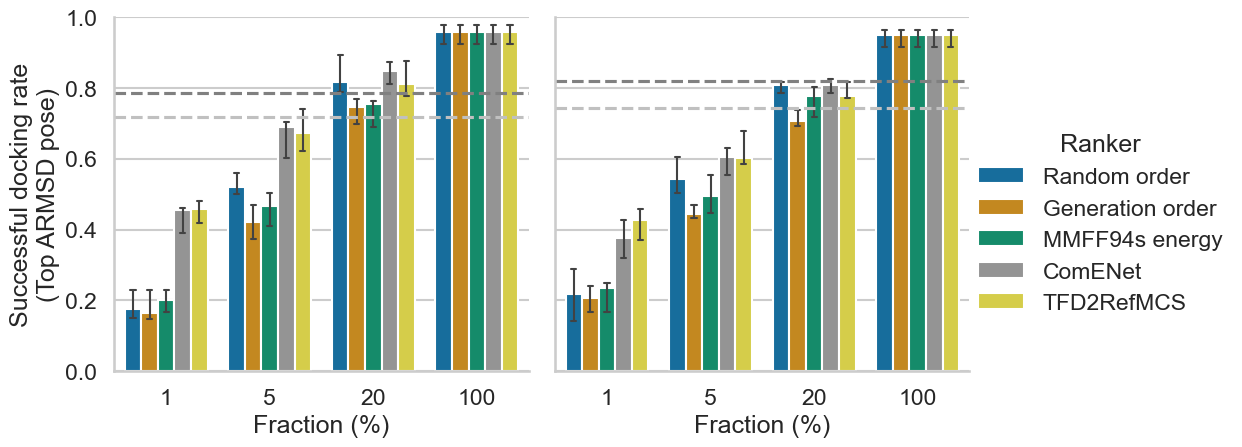

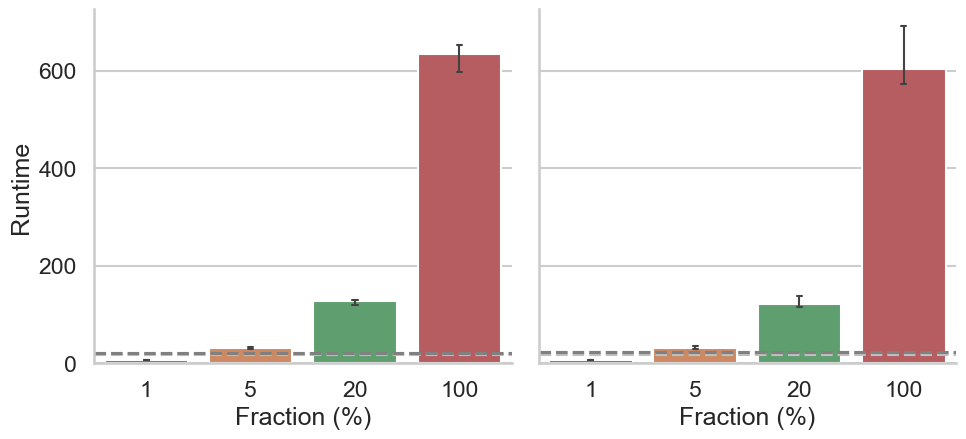

In [39]:
uniprot_ids = pdbbind_df['Uniprot ID'].values
df = pdbbind_analysis_for_uniprot_ids(uniprot_ids, 
                                      only_good_docking=False,
                                     task='hard')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1394/1394 [00:00<00:00, 6654.95it/s]


Reading files


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1311/1311 [00:00<00:00, 5810.27it/s]


Reading files


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1438/1438 [00:00<00:00, 6174.64it/s]


Reading files


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1352/1352 [00:00<00:00, 6306.61it/s]


Reading files


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1350/1350 [00:00<00:00, 6336.88it/s]


Reading files


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1566/1566 [00:00<00:00, 6269.42it/s]


Reading files


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1264/1264 [00:00<00:00, 6146.04it/s]


Reading files


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1204/1204 [00:00<00:00, 5764.68it/s]


Reading files


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1319/1319 [00:00<00:00, 6909.87it/s]


Reading files


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1322/1322 [00:00<00:00, 6200.37it/s]


Reading files


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 927/927 [00:01<00:00, 769.13it/s]


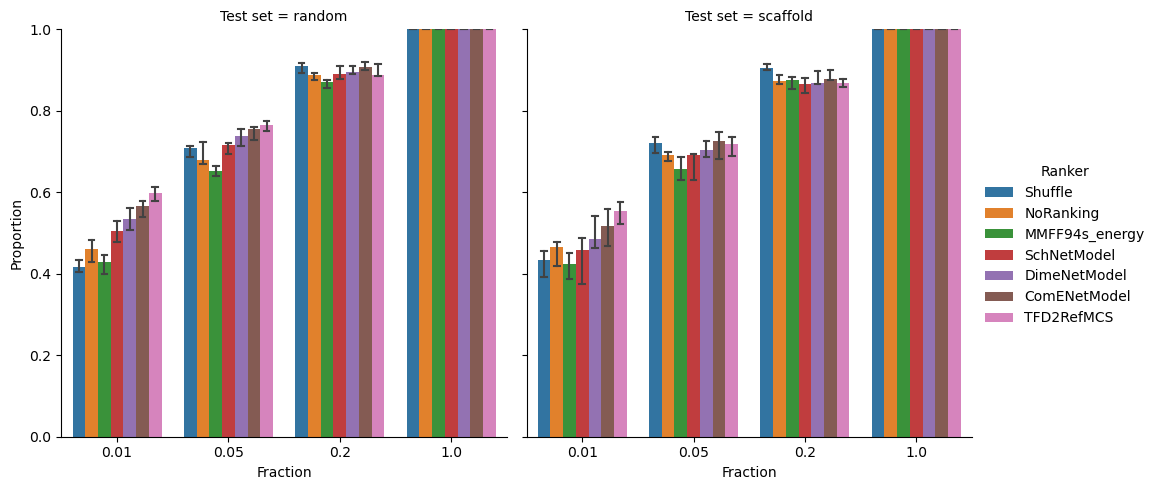

In [6]:
uniprot_ids = pdbbind_df['Uniprot ID'].values
df = pdbbind_analysis_for_uniprot_ids(uniprot_ids, only_good_docking=True)

In [40]:
ec = ENZYMEConnector()
enzyme_table = ec.get_table()
pdbbind_df = pdbbind_df.merge(enzyme_table, left_on='Uniprot ID', right_on='uniprot_id')

Loading enzyme classes data


100%|███████████████████████████████| 163761/163761 [00:00<00:00, 853447.92it/s]


2.7.11


100%|████████████████████████████████████| 1394/1394 [00:00<00:00, 45572.49it/s]


Reading files


100%|████████████████████████████████████| 1311/1311 [00:00<00:00, 43023.72it/s]


Reading files


100%|████████████████████████████████████| 1438/1438 [00:00<00:00, 38759.53it/s]


Reading files


100%|████████████████████████████████████| 1352/1352 [00:00<00:00, 43271.26it/s]


Reading files


100%|████████████████████████████████████| 1350/1350 [00:00<00:00, 43078.72it/s]


Reading files


100%|████████████████████████████████████| 1566/1566 [00:00<00:00, 43529.39it/s]


Reading files


100%|████████████████████████████████████| 1264/1264 [00:00<00:00, 42148.78it/s]


Reading files


100%|████████████████████████████████████| 1204/1204 [00:00<00:00, 40329.52it/s]


Reading files


100%|████████████████████████████████████| 1319/1319 [00:00<00:00, 47168.40it/s]


Reading files


100%|████████████████████████████████████| 1322/1322 [00:00<00:00, 44762.18it/s]


Reading files


100%|████████████████████████████████████████| 129/129 [00:00<00:00, 648.16it/s]


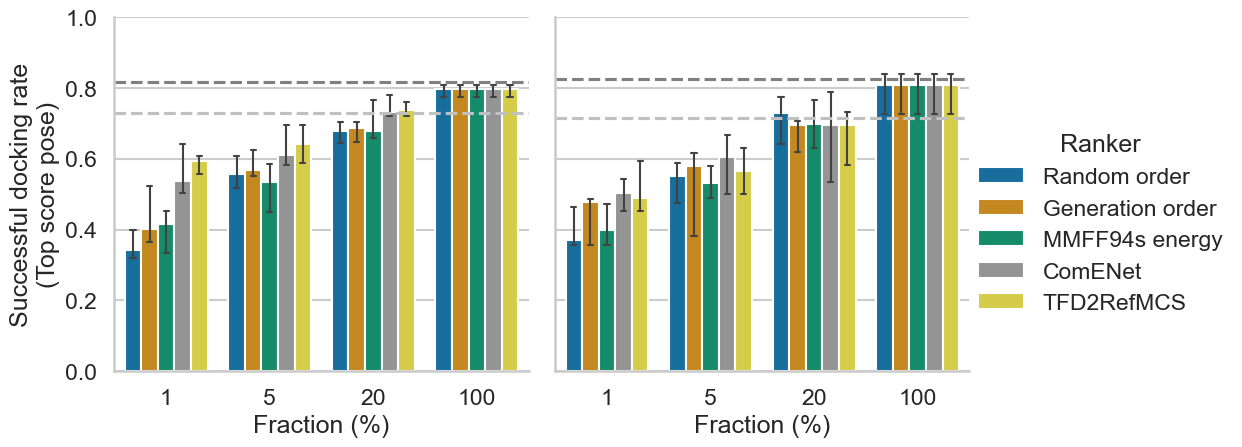

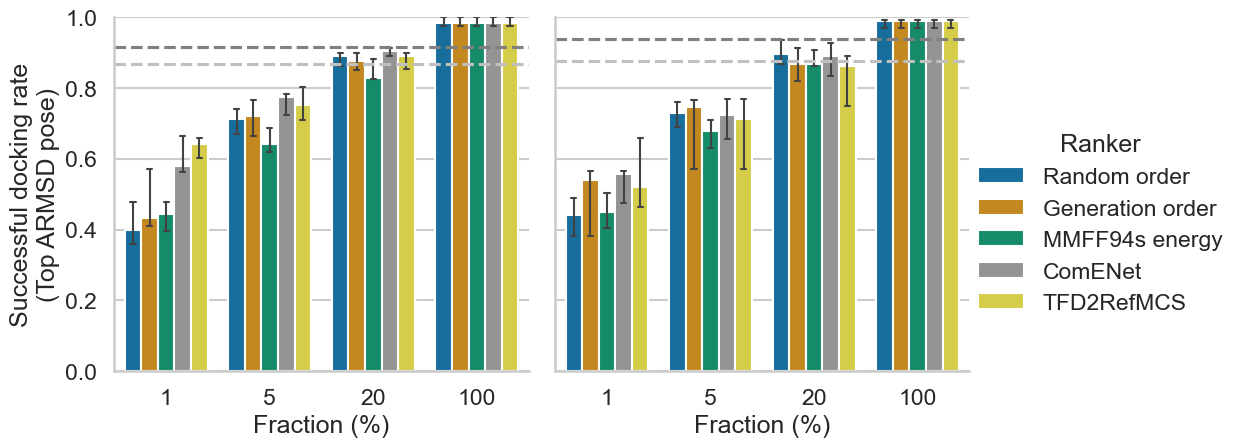

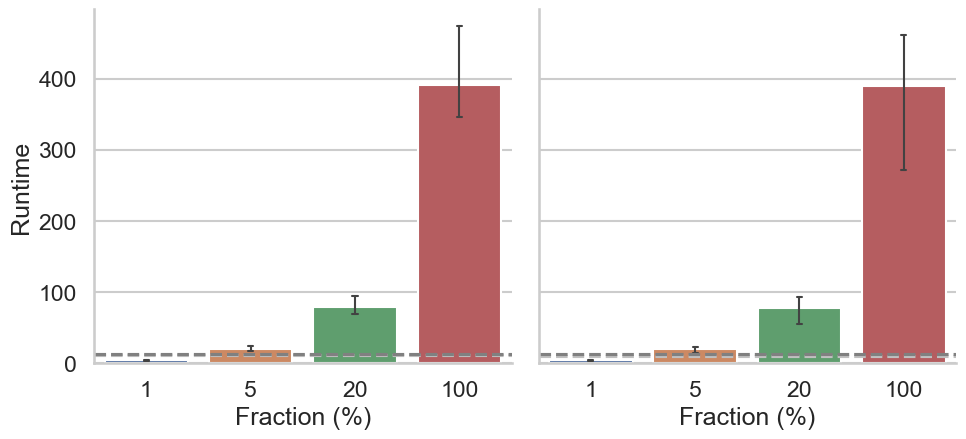

2.7.10


100%|████████████████████████████████████| 1394/1394 [00:00<00:00, 71545.73it/s]


Reading files


100%|████████████████████████████████████| 1311/1311 [00:00<00:00, 86849.98it/s]


Reading files


100%|████████████████████████████████████| 1438/1438 [00:00<00:00, 87505.57it/s]


Reading files


100%|████████████████████████████████████| 1352/1352 [00:00<00:00, 91067.77it/s]


Reading files


100%|████████████████████████████████████| 1350/1350 [00:00<00:00, 87506.92it/s]


Reading files


100%|████████████████████████████████████| 1566/1566 [00:00<00:00, 86031.93it/s]


Reading files


100%|████████████████████████████████████| 1264/1264 [00:00<00:00, 77082.79it/s]


Reading files


100%|████████████████████████████████████| 1204/1204 [00:00<00:00, 77410.36it/s]


Reading files


100%|████████████████████████████████████| 1319/1319 [00:00<00:00, 85476.37it/s]


Reading files


100%|████████████████████████████████████| 1322/1322 [00:00<00:00, 82471.22it/s]


Reading files


100%|██████████████████████████████████████████| 70/70 [00:00<00:00, 755.15it/s]


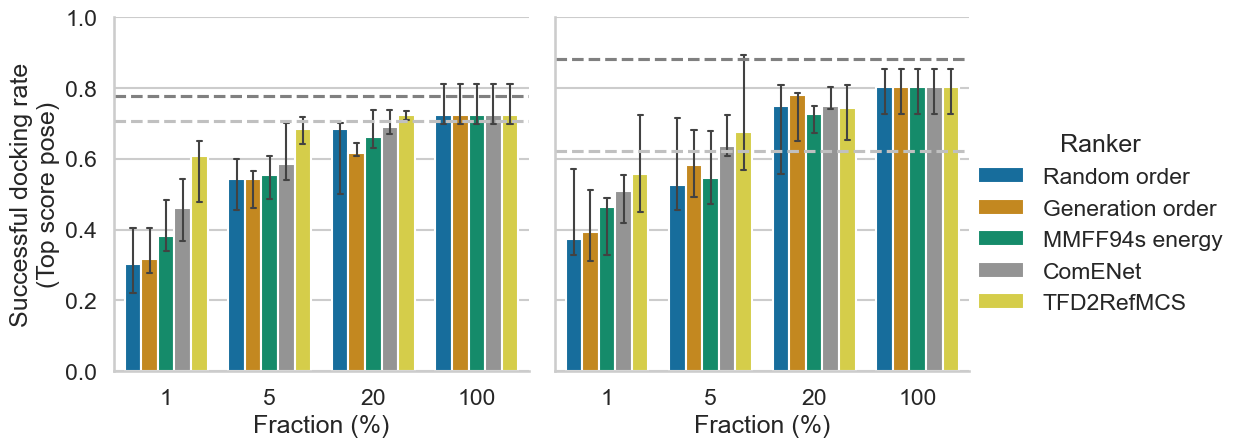

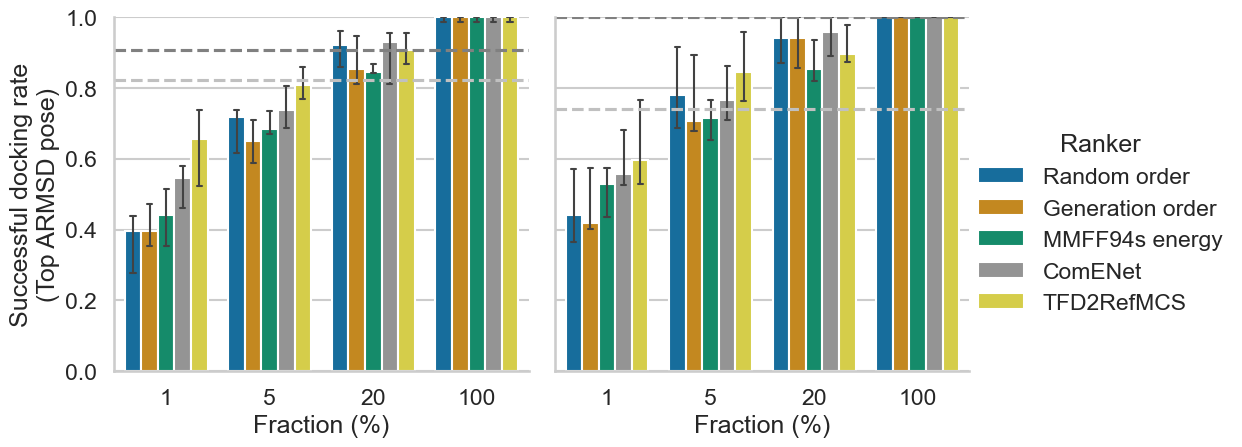

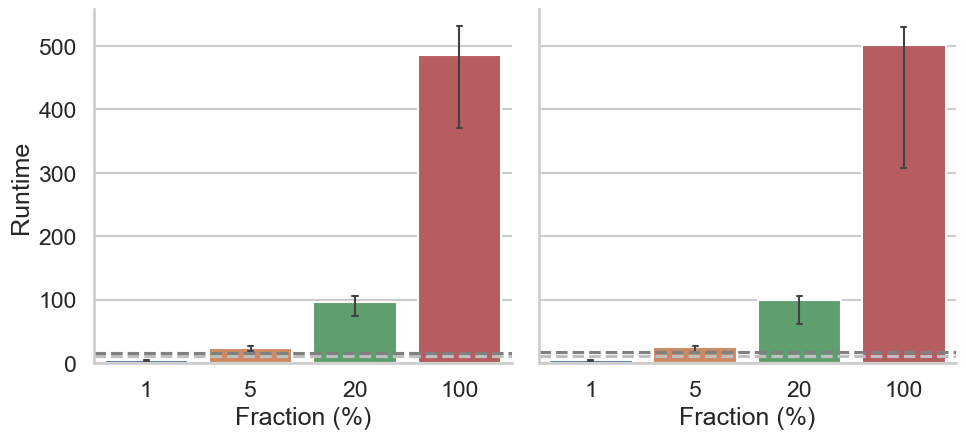

3.4.21


100%|████████████████████████████████████| 1394/1394 [00:00<00:00, 78094.54it/s]


Reading files


100%|████████████████████████████████████| 1311/1311 [00:00<00:00, 70191.51it/s]


Reading files


100%|████████████████████████████████████| 1438/1438 [00:00<00:00, 66965.06it/s]


Reading files


100%|████████████████████████████████████| 1352/1352 [00:00<00:00, 70425.09it/s]


Reading files


100%|████████████████████████████████████| 1350/1350 [00:00<00:00, 69786.17it/s]


Reading files


100%|████████████████████████████████████| 1566/1566 [00:00<00:00, 66731.82it/s]


Reading files


100%|████████████████████████████████████| 1264/1264 [00:00<00:00, 64495.57it/s]


Reading files


100%|████████████████████████████████████| 1204/1204 [00:00<00:00, 62582.93it/s]


Reading files


100%|████████████████████████████████████| 1319/1319 [00:00<00:00, 69805.40it/s]


Reading files


100%|████████████████████████████████████| 1322/1322 [00:00<00:00, 72438.40it/s]


Reading files


100%|██████████████████████████████████████████| 56/56 [00:00<00:00, 740.54it/s]


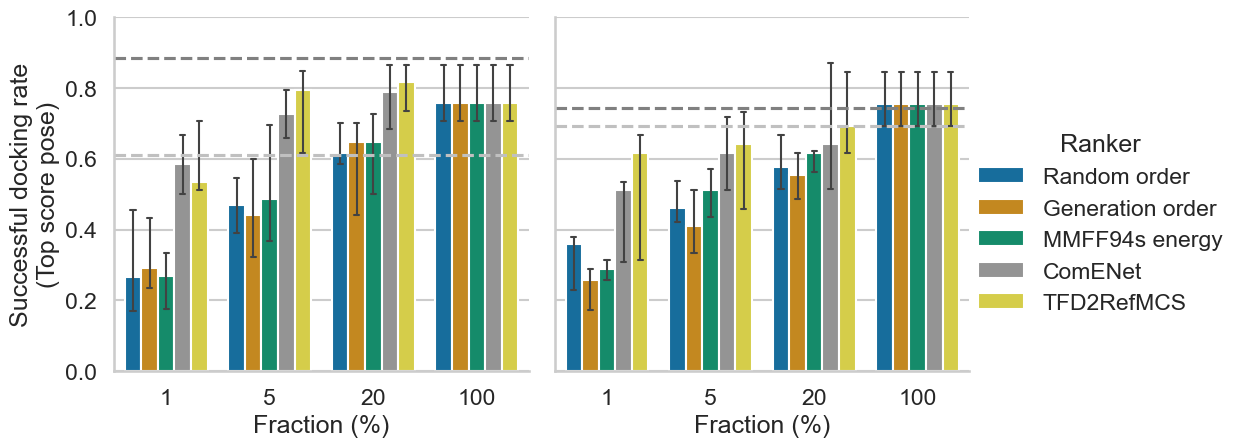

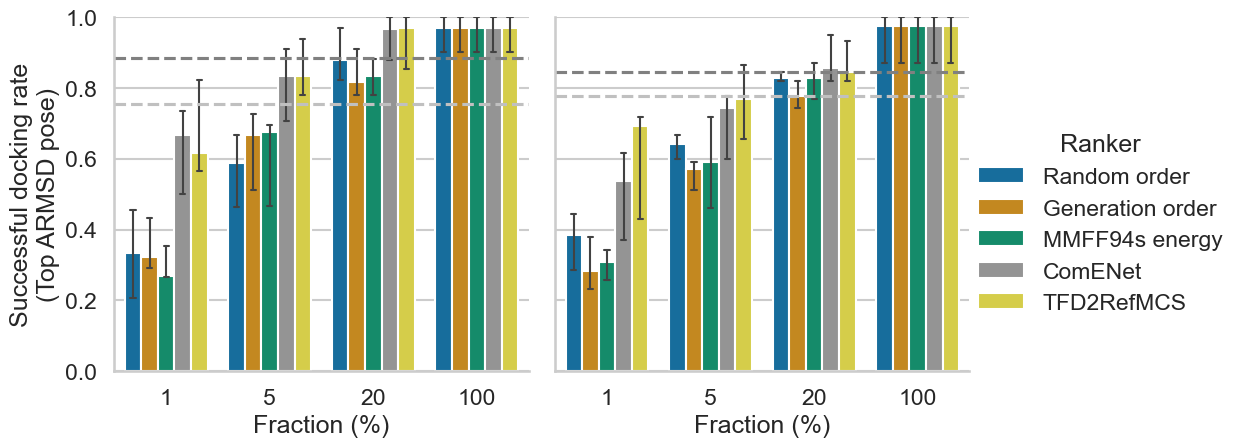

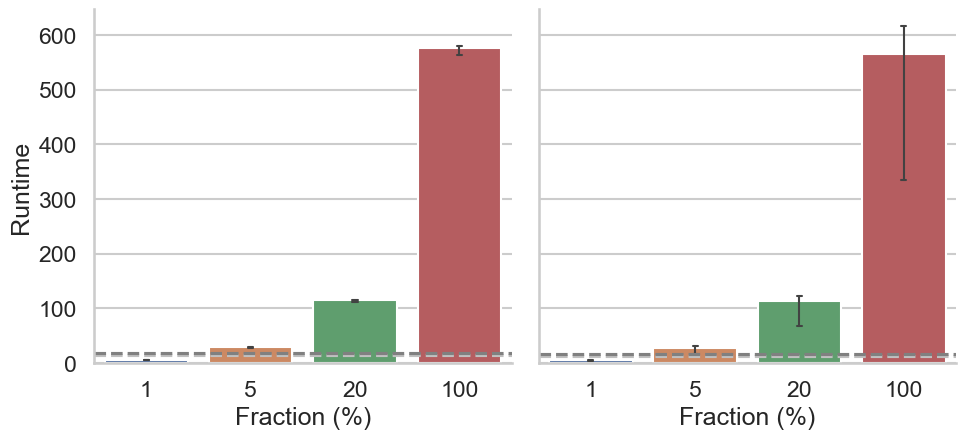

4.2.1


100%|████████████████████████████████████| 1394/1394 [00:00<00:00, 95261.41it/s]


Reading files


100%|████████████████████████████████████| 1311/1311 [00:00<00:00, 84821.64it/s]


Reading files


100%|████████████████████████████████████| 1438/1438 [00:00<00:00, 86214.72it/s]


Reading files


100%|████████████████████████████████████| 1352/1352 [00:00<00:00, 89024.76it/s]


Reading files


100%|████████████████████████████████████| 1350/1350 [00:00<00:00, 85101.45it/s]


Reading files


100%|████████████████████████████████████| 1566/1566 [00:00<00:00, 86826.88it/s]


Reading files


100%|████████████████████████████████████| 1264/1264 [00:00<00:00, 81138.66it/s]


Reading files


100%|████████████████████████████████████| 1204/1204 [00:00<00:00, 83624.93it/s]


Reading files


100%|████████████████████████████████████| 1319/1319 [00:00<00:00, 93729.45it/s]


Reading files


100%|████████████████████████████████████| 1322/1322 [00:00<00:00, 87193.09it/s]


Reading files


100%|██████████████████████████████████████████| 25/25 [00:00<00:00, 565.31it/s]


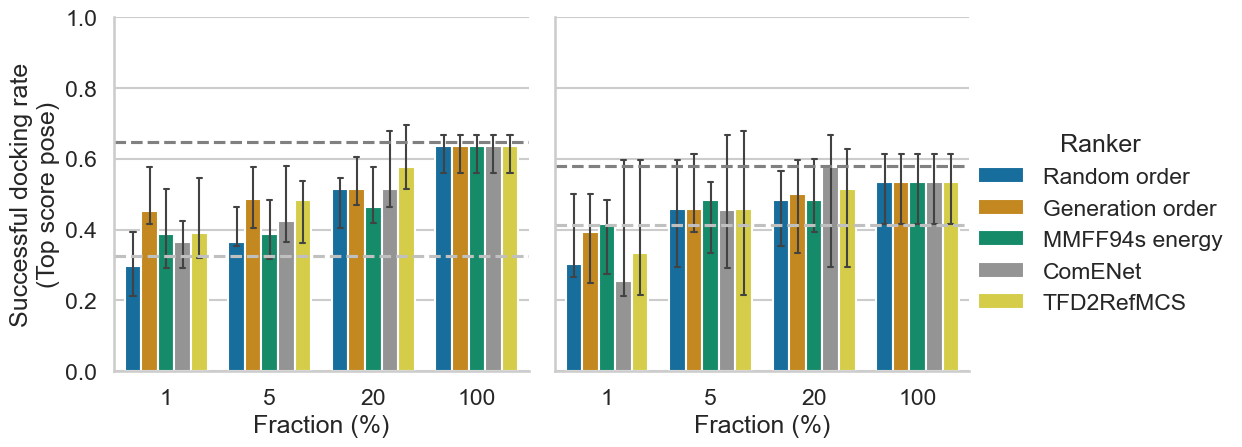

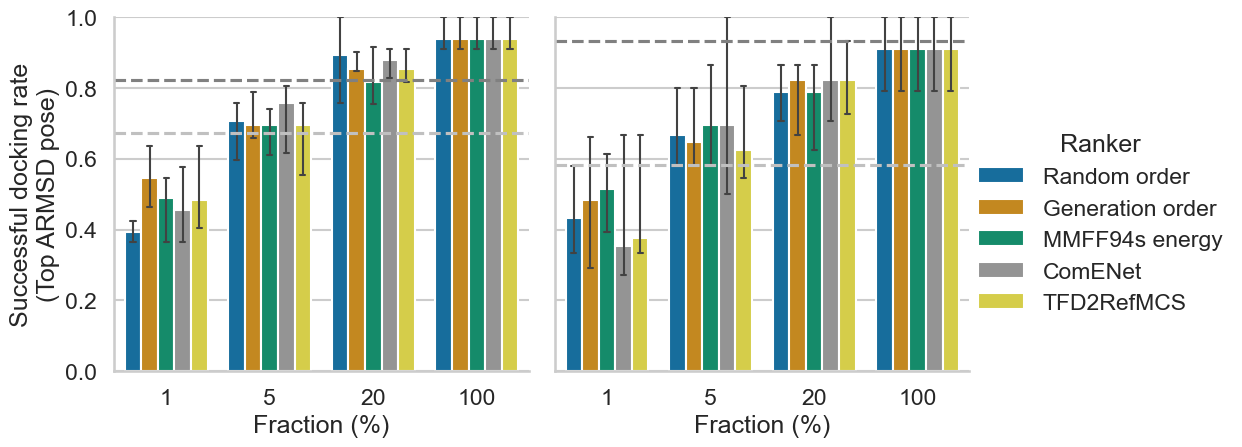

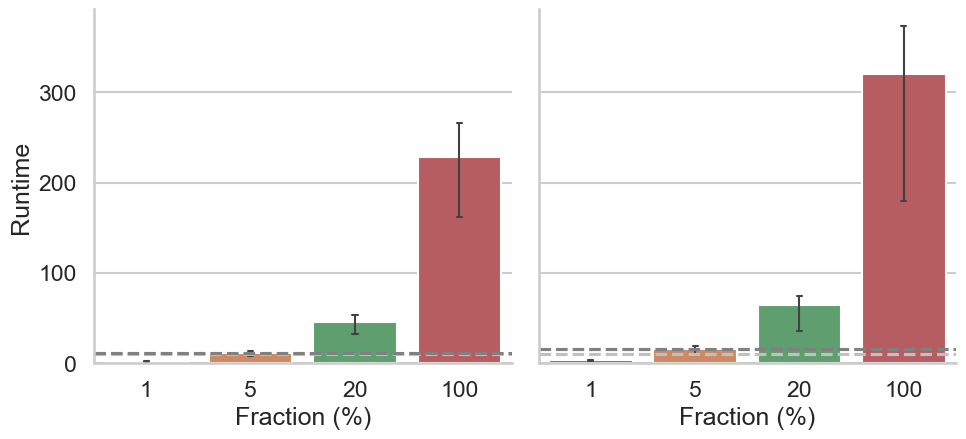

2.7.7


100%|████████████████████████████████████| 1394/1394 [00:00<00:00, 43109.53it/s]


Reading files


100%|████████████████████████████████████| 1311/1311 [00:00<00:00, 39798.30it/s]


Reading files


100%|████████████████████████████████████| 1438/1438 [00:00<00:00, 37766.41it/s]


Reading files


100%|████████████████████████████████████| 1352/1352 [00:00<00:00, 39504.40it/s]


Reading files


100%|████████████████████████████████████| 1350/1350 [00:00<00:00, 37026.47it/s]


Reading files


100%|████████████████████████████████████| 1566/1566 [00:00<00:00, 37975.94it/s]


Reading files


100%|████████████████████████████████████| 1264/1264 [00:00<00:00, 38322.42it/s]


Reading files


100%|████████████████████████████████████| 1204/1204 [00:00<00:00, 36664.45it/s]


Reading files


100%|████████████████████████████████████| 1319/1319 [00:00<00:00, 41351.76it/s]


Reading files


100%|████████████████████████████████████| 1322/1322 [00:00<00:00, 40420.10it/s]


Reading files


100%|██████████████████████████████████████████| 27/27 [00:00<00:00, 622.67it/s]


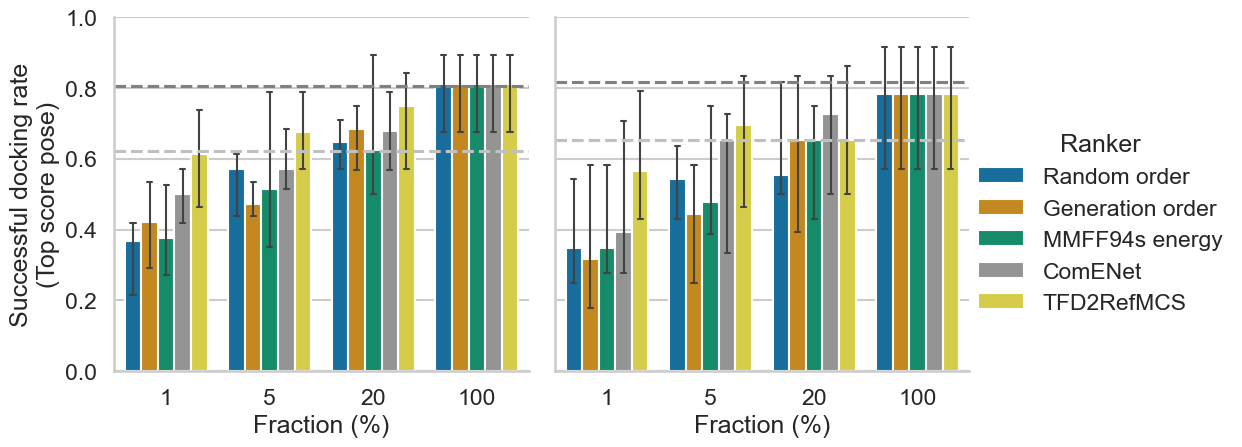

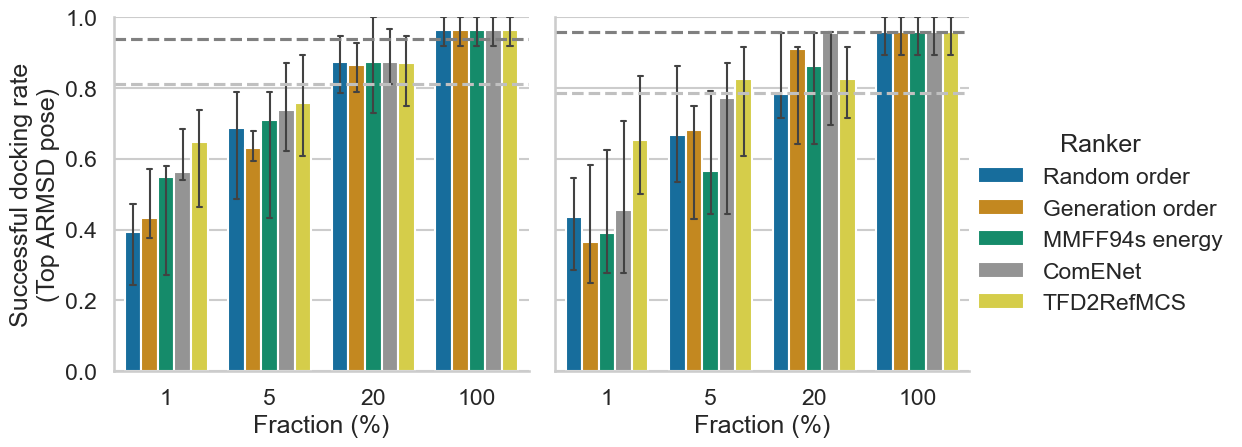

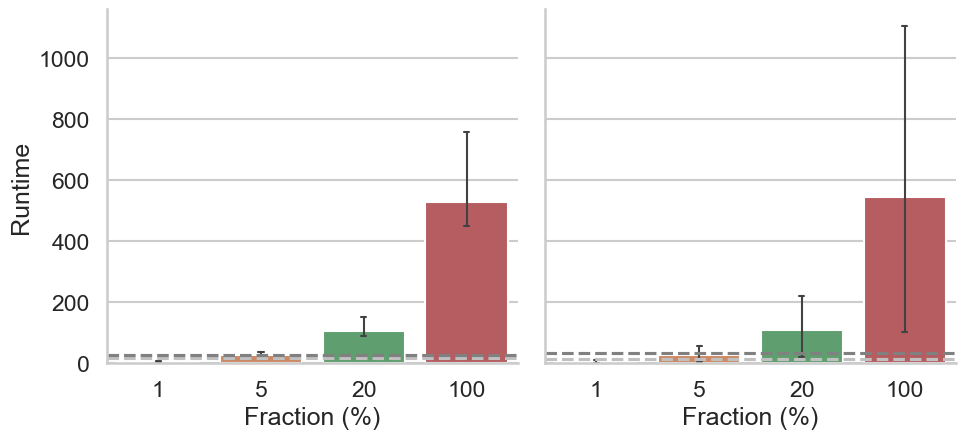

3.4.23


100%|████████████████████████████████████| 1394/1394 [00:00<00:00, 46445.67it/s]


Reading files


100%|████████████████████████████████████| 1311/1311 [00:00<00:00, 44563.48it/s]


Reading files


100%|████████████████████████████████████| 1438/1438 [00:00<00:00, 43851.08it/s]


Reading files


100%|████████████████████████████████████| 1352/1352 [00:00<00:00, 46887.37it/s]


Reading files


100%|████████████████████████████████████| 1350/1350 [00:00<00:00, 44231.27it/s]


Reading files


100%|████████████████████████████████████| 1566/1566 [00:00<00:00, 44806.23it/s]


Reading files


100%|████████████████████████████████████| 1264/1264 [00:00<00:00, 42356.21it/s]


Reading files


100%|████████████████████████████████████| 1204/1204 [00:00<00:00, 42182.33it/s]


Reading files


100%|████████████████████████████████████| 1319/1319 [00:00<00:00, 47104.14it/s]


Reading files


100%|████████████████████████████████████| 1322/1322 [00:00<00:00, 45403.98it/s]


Reading files


100%|██████████████████████████████████████████| 29/29 [00:00<00:00, 593.46it/s]


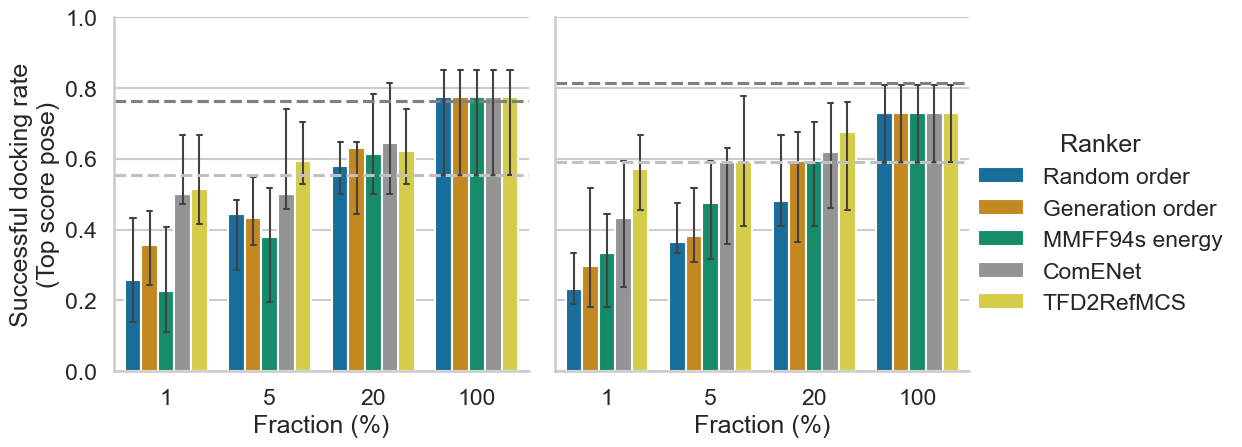

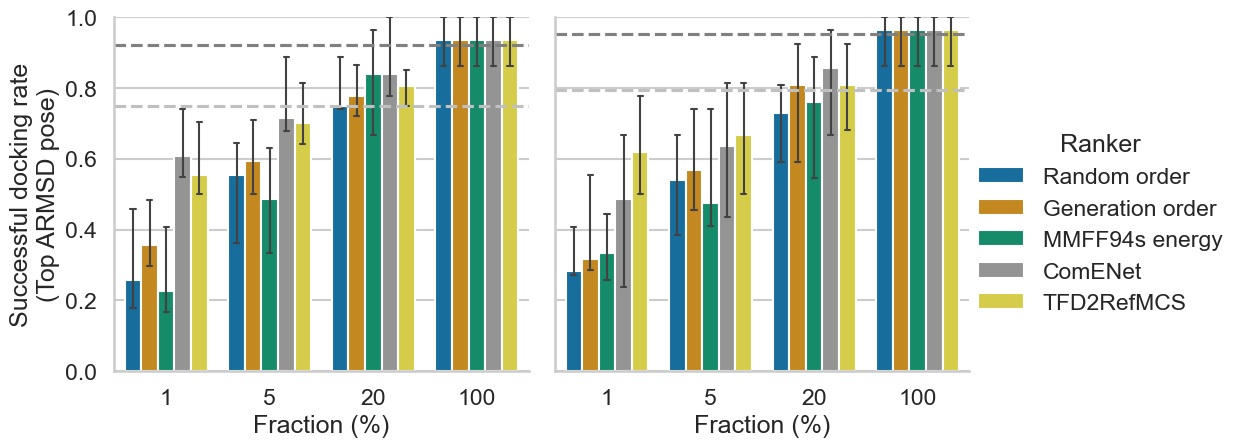

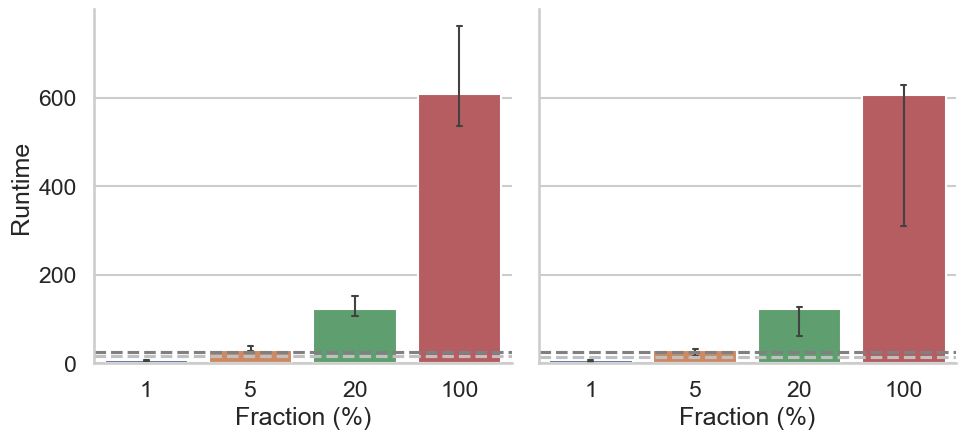

2.4.2


100%|███████████████████████████████████| 1394/1394 [00:00<00:00, 191136.31it/s]


Reading files


100%|███████████████████████████████████| 1311/1311 [00:00<00:00, 169118.92it/s]


Reading files


100%|███████████████████████████████████| 1438/1438 [00:00<00:00, 173316.35it/s]


Reading files


100%|███████████████████████████████████| 1352/1352 [00:00<00:00, 173019.04it/s]


Reading files


100%|███████████████████████████████████| 1350/1350 [00:00<00:00, 170685.19it/s]


Reading files


100%|███████████████████████████████████| 1566/1566 [00:00<00:00, 177501.89it/s]


Reading files


100%|███████████████████████████████████| 1264/1264 [00:00<00:00, 167011.10it/s]


Reading files


100%|███████████████████████████████████| 1204/1204 [00:00<00:00, 167117.02it/s]


Reading files


100%|███████████████████████████████████| 1319/1319 [00:00<00:00, 189176.82it/s]


Reading files


100%|███████████████████████████████████| 1322/1322 [00:00<00:00, 176773.99it/s]


Reading files


100%|█████████████████████████████████████████| 30/30 [00:00<00:00, 1576.08it/s]


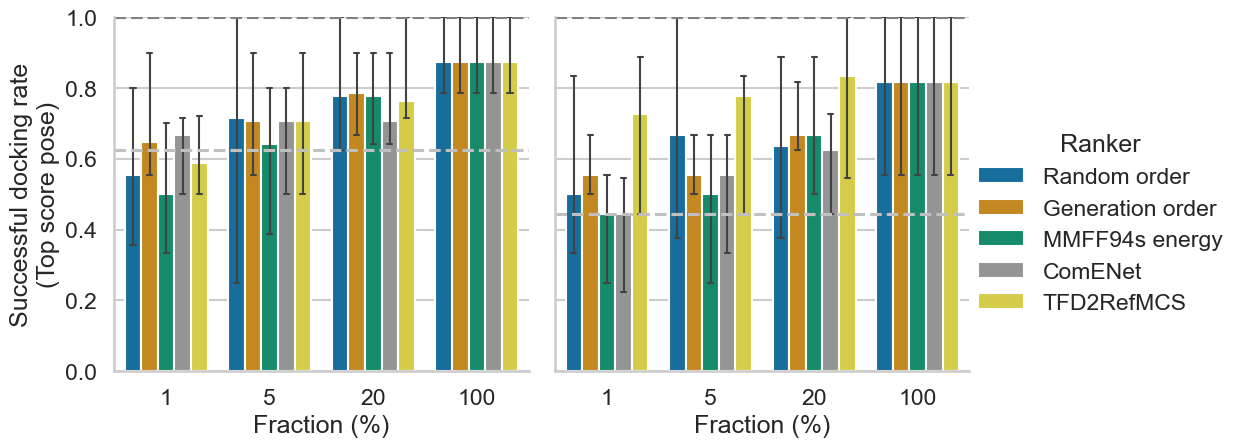

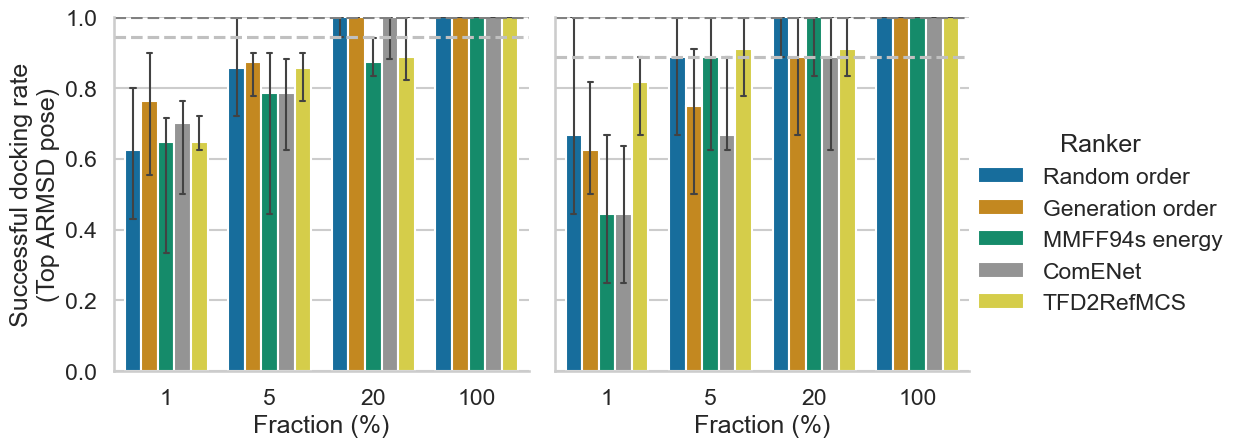

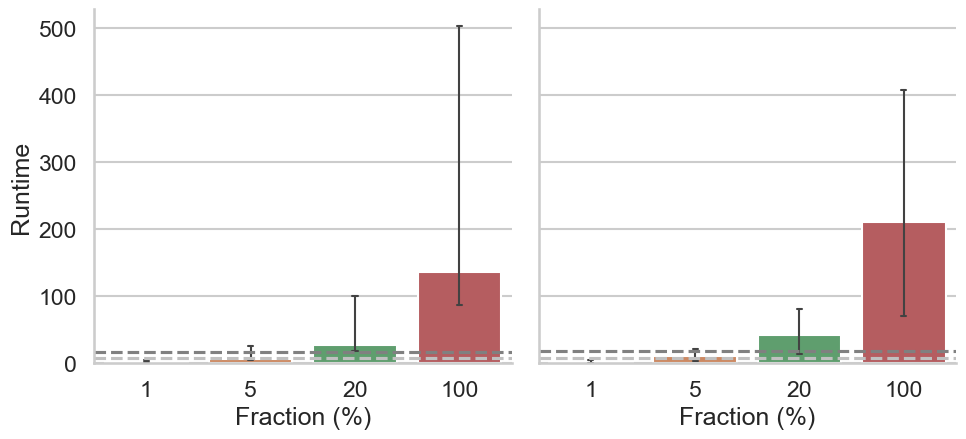

2.1.1


100%|███████████████████████████████████| 1394/1394 [00:00<00:00, 155692.06it/s]


Reading files


100%|███████████████████████████████████| 1311/1311 [00:00<00:00, 138576.93it/s]


Reading files


100%|███████████████████████████████████| 1438/1438 [00:00<00:00, 145739.02it/s]


Reading files


100%|███████████████████████████████████| 1352/1352 [00:00<00:00, 146757.22it/s]


Reading files


100%|███████████████████████████████████| 1350/1350 [00:00<00:00, 140776.45it/s]


Reading files


100%|███████████████████████████████████| 1566/1566 [00:00<00:00, 146502.21it/s]


Reading files


100%|███████████████████████████████████| 1264/1264 [00:00<00:00, 138224.49it/s]


Reading files


100%|███████████████████████████████████| 1204/1204 [00:00<00:00, 136543.97it/s]


Reading files


100%|███████████████████████████████████| 1319/1319 [00:00<00:00, 156904.25it/s]


Reading files


100%|███████████████████████████████████| 1322/1322 [00:00<00:00, 145653.15it/s]


Reading files


100%|█████████████████████████████████████████| 18/18 [00:00<00:00, 1459.59it/s]


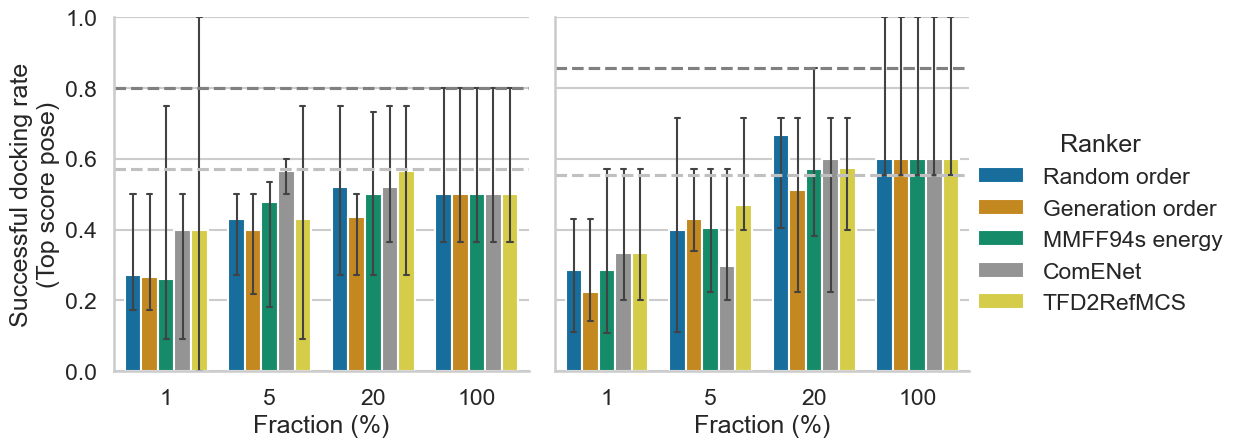

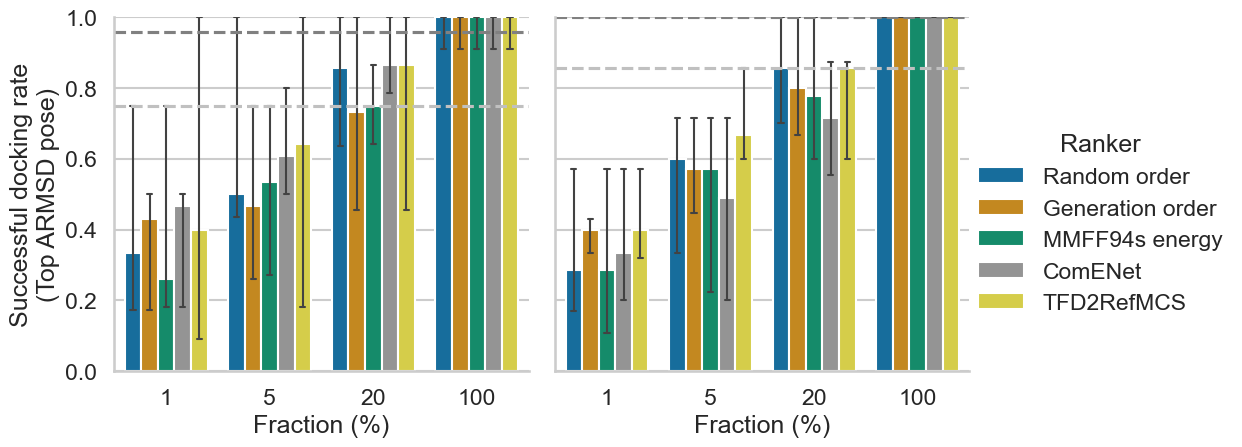

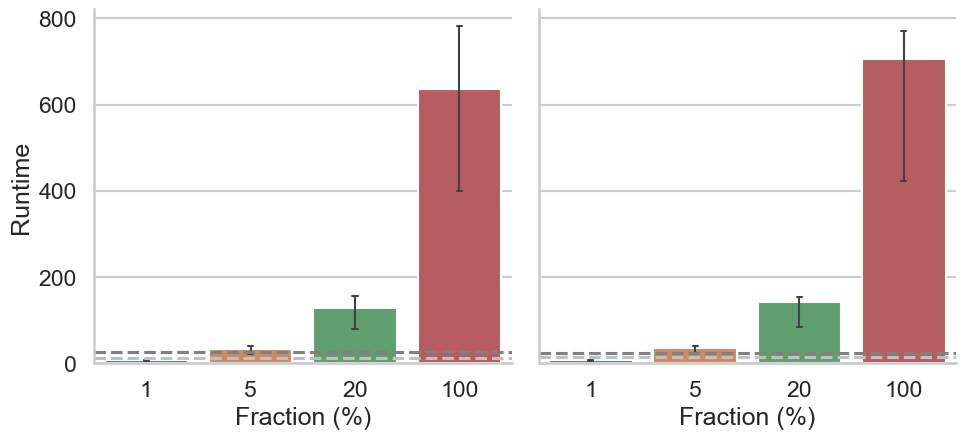

3.2.1


100%|███████████████████████████████████| 1394/1394 [00:00<00:00, 187243.32it/s]


Reading files


100%|███████████████████████████████████| 1311/1311 [00:00<00:00, 173505.38it/s]


Reading files


100%|███████████████████████████████████| 1438/1438 [00:00<00:00, 174712.04it/s]


Reading files


100%|███████████████████████████████████| 1352/1352 [00:00<00:00, 171620.94it/s]


Reading files


100%|███████████████████████████████████| 1350/1350 [00:00<00:00, 172631.41it/s]


Reading files


100%|███████████████████████████████████| 1566/1566 [00:00<00:00, 179006.35it/s]


Reading files


100%|███████████████████████████████████| 1264/1264 [00:00<00:00, 169363.97it/s]


Reading files


100%|███████████████████████████████████| 1204/1204 [00:00<00:00, 165133.32it/s]


Reading files


100%|███████████████████████████████████| 1319/1319 [00:00<00:00, 183943.58it/s]


Reading files


100%|███████████████████████████████████| 1322/1322 [00:00<00:00, 179532.78it/s]


Reading files


100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 634.68it/s]


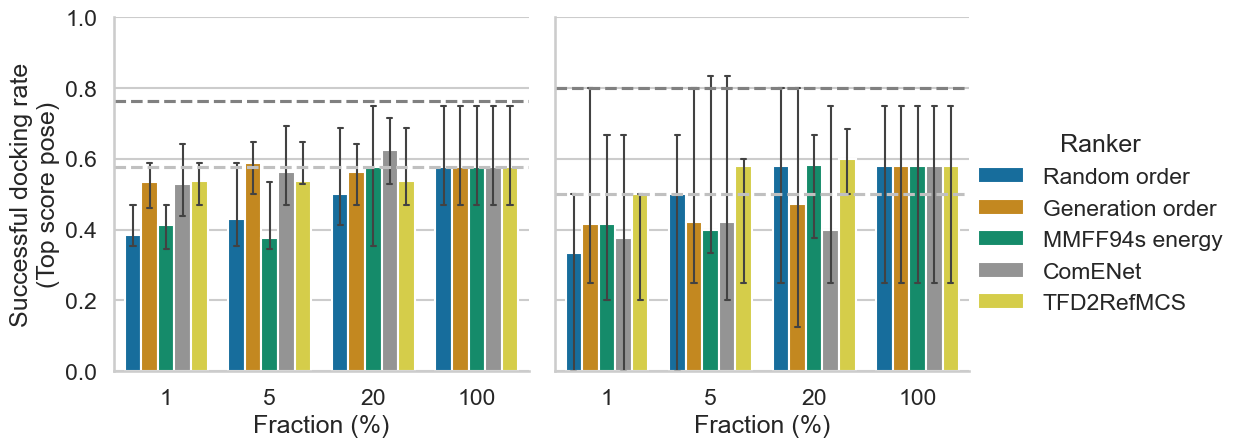

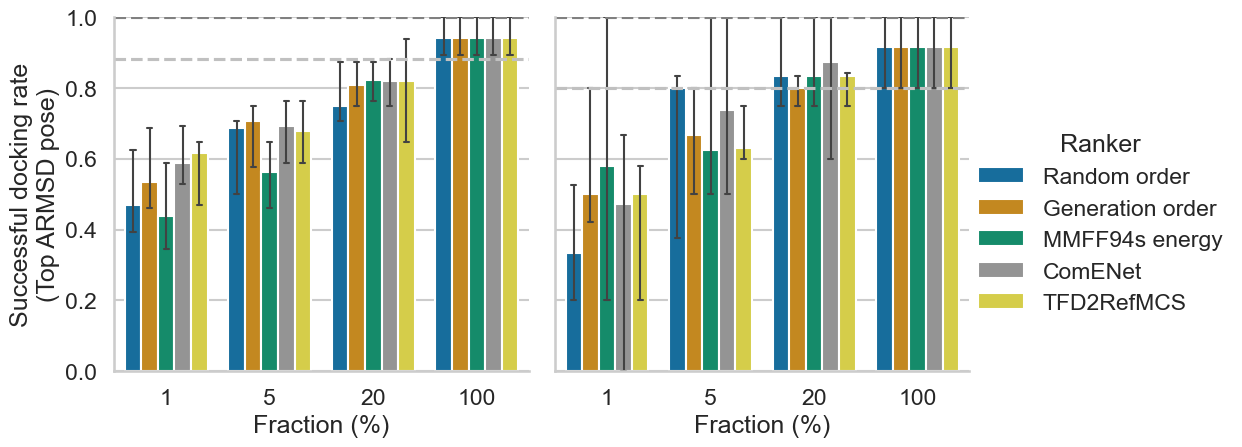

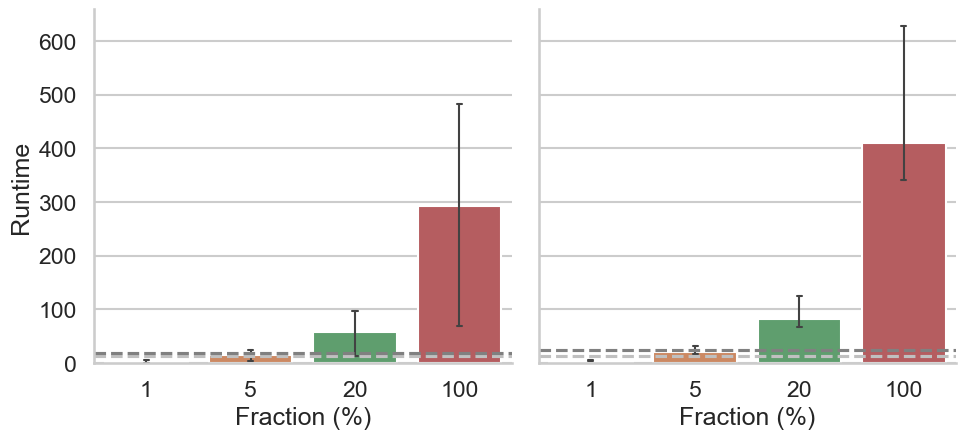

3.1.3


100%|███████████████████████████████████| 1394/1394 [00:00<00:00, 163828.06it/s]


Reading files


100%|███████████████████████████████████| 1311/1311 [00:00<00:00, 152070.92it/s]


Reading files


100%|███████████████████████████████████| 1438/1438 [00:00<00:00, 158421.13it/s]


Reading files


100%|███████████████████████████████████| 1352/1352 [00:00<00:00, 163227.86it/s]


Reading files


100%|███████████████████████████████████| 1350/1350 [00:00<00:00, 157020.34it/s]


Reading files


100%|███████████████████████████████████| 1566/1566 [00:00<00:00, 162099.71it/s]


Reading files


100%|███████████████████████████████████| 1264/1264 [00:00<00:00, 148454.31it/s]


Reading files


100%|███████████████████████████████████| 1204/1204 [00:00<00:00, 154055.58it/s]


Reading files


100%|███████████████████████████████████| 1319/1319 [00:00<00:00, 177010.53it/s]


Reading files


100%|███████████████████████████████████| 1322/1322 [00:00<00:00, 160823.42it/s]


Reading files


100%|██████████████████████████████████████████| 13/13 [00:00<00:00, 591.49it/s]


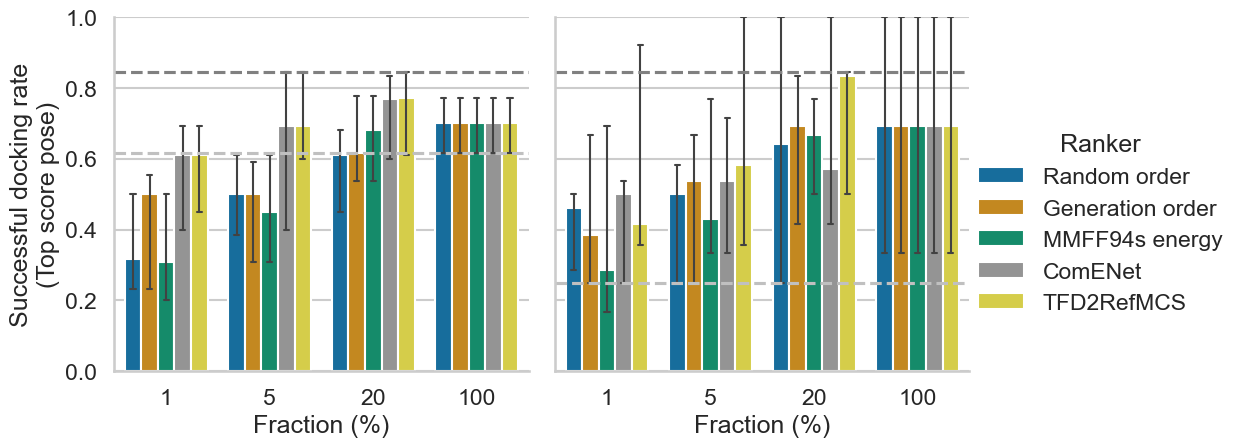

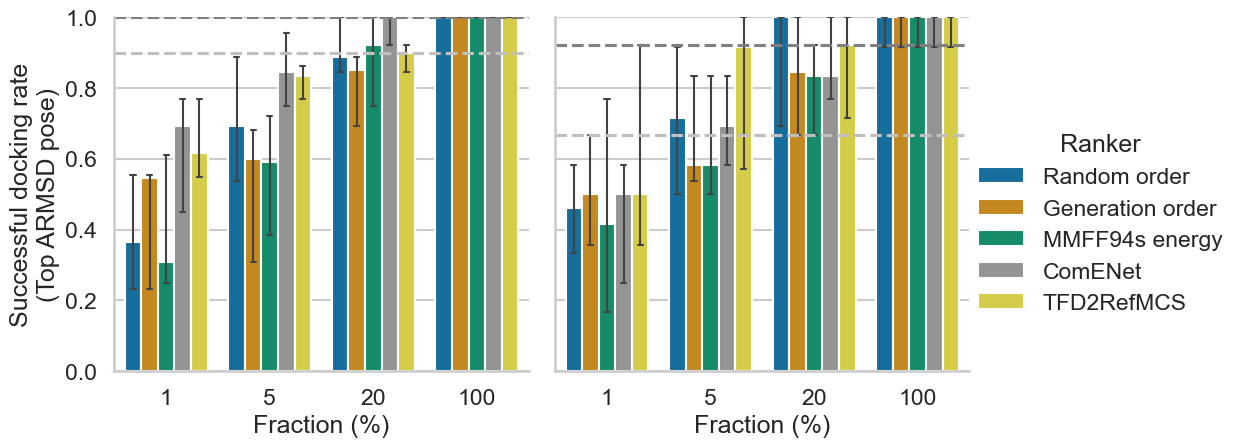

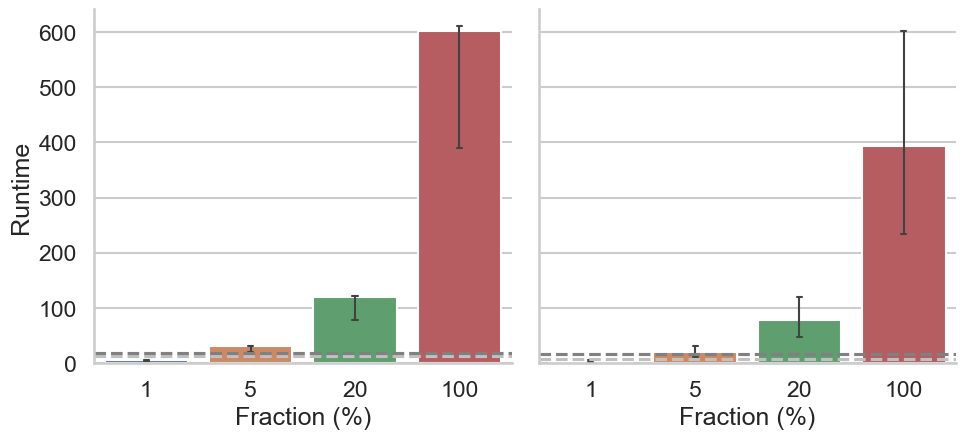

In [41]:
# enzyme_classes = ['2.7.10', '2.7.11', '3.4.21', '3.4.23']
enzyme_classes = ['2.7.11', '2.7.10', '3.4.21', '4.2.1', '2.7.7',
                 '3.4.23', '2.4.2', '2.1.1', '3.2.1', '3.1.3']
dfs = []
for enzyme_class in enzyme_classes:
    print(enzyme_class)
    uniprot_ids = pdbbind_df[pdbbind_df['level_3_combined'] == enzyme_class]['Uniprot ID'].values
    df = pdbbind_analysis_for_uniprot_ids(uniprot_ids, 
                                          only_good_docking=False,
                                         subset_name=enzyme_class)
    df['Enzyme class'] = enzyme_class
    dfs.append(df)
    # df = pdbbind_analysis_for_uniprot_ids(uniprot_ids, only_good_docking=True)

In [103]:
master_df = pd.concat(dfs)

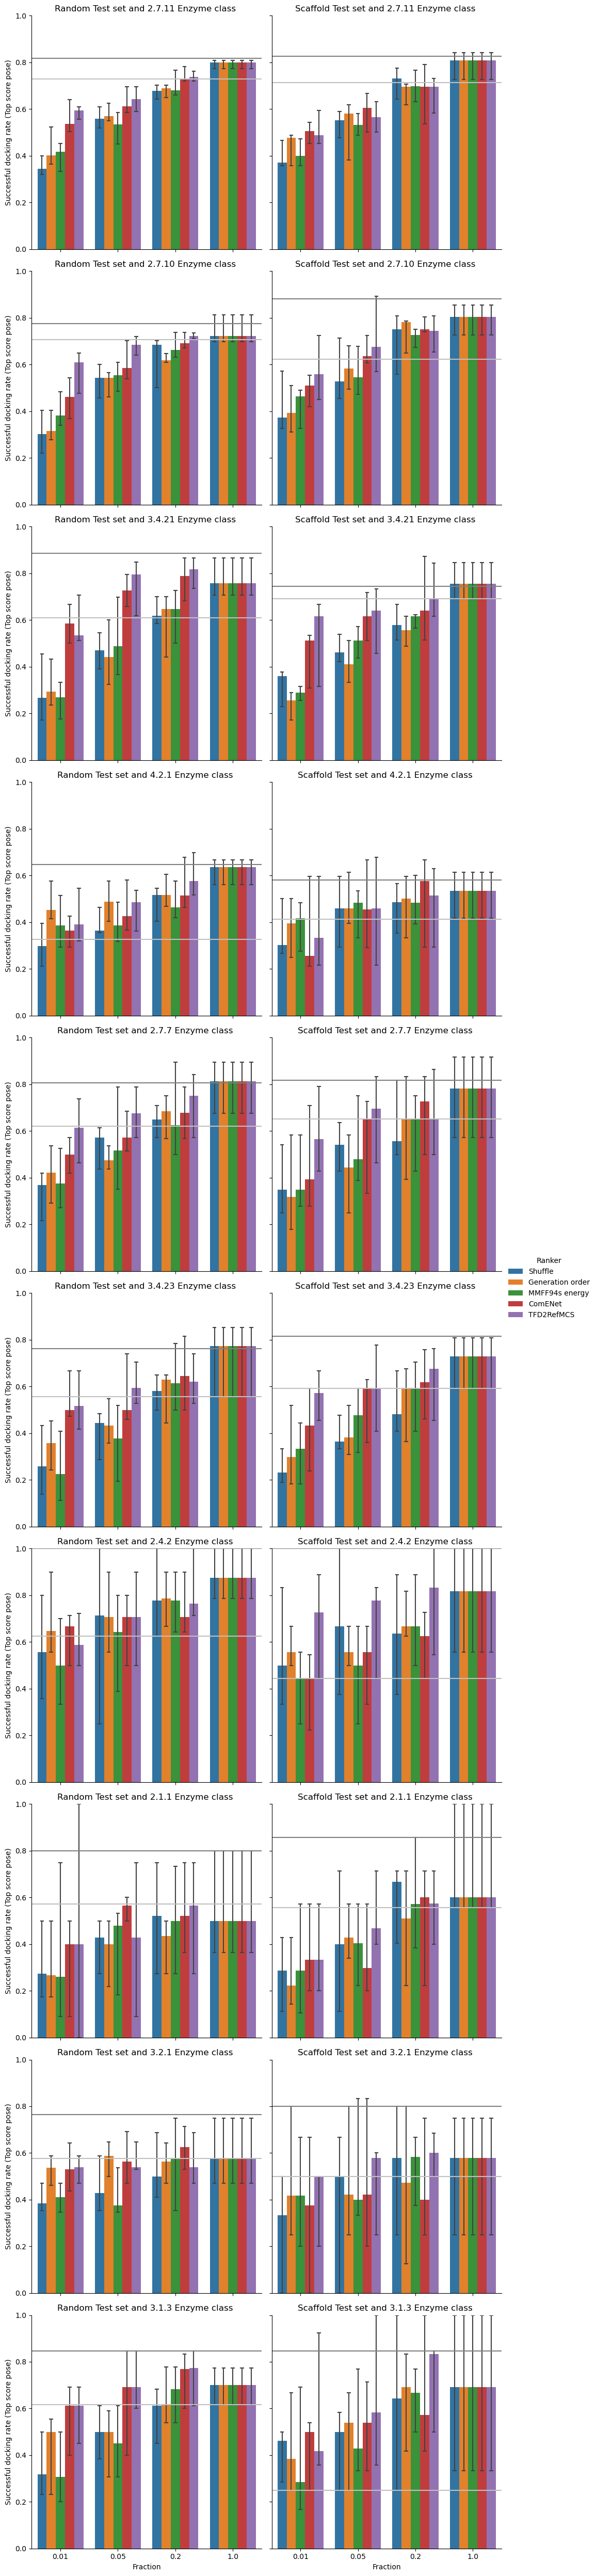

In [114]:
clean_metric = 'Top score pose'
fig = sns.catplot(data=master_df[(master_df['Metric'] == clean_metric)
                                       &(master_df['Ranker'] != 'Flexible')],
             x='Fraction',
            y='Docking power',
            hue='Ranker',
            errorbar=('pi', 100),
           kind='bar',
           col='Test set',
           row='Enzyme class',
           estimator='median',
           errwidth=1.5,
           capsize=0.05)
# fig.set_titles('{col_name} {col_var}')
fig.set_ylabels(f'Successful docking rate ({clean_metric})')
plt.ylim(0, 1)
test_sets = ['Random', 'Scaffold']
for axes, enzyme_class in zip(fig.axes, enzyme_classes):
    for ax, test_set in zip(axes, test_sets):
        subset_df = master_df[(master_df['Ranker'] == 'Flexible')
                                    &(master_df['Metric'] == clean_metric)
                                    &(master_df['Test set'] == test_set)
                                    &(master_df['Enzyme class'] == enzyme_class)]
        min_flexible = subset_df['Docking power'].min()
        max_flexible = subset_df['Docking power'].max()
        ax.axhline(min_flexible, c='silver', label='Flexible')
        ax.axhline(max_flexible, c='grey', label='Flexible')
        ax.set_title(f'{test_set} Test set and {enzyme_class} Enzyme class ')

plt.savefig(os.path.join(figures_dir, f'{clean_metric}_enzyme_classes.png'))
plt.show()

In [112]:
master_df[master_df['Enzyme class'] == '3.4.21'].groupby(['Test set', 'Ranker', 'Fraction', 'Metric'], 
           sort=False).agg(custom_agg).reset_index().pivot_table(index=['Test set', 'Metric', 'Fraction'], 
                                                                 columns='Ranker', 
                                                                 values='Docking power',
                                                                 aggfunc='first')

Ranker                                ComENet     Flexible Generation order  \
Test set Metric         Fraction                                              
Random   Top ARMSD pose 0.01       0.64 ± 0.1          NaN      0.35 ± 0.07   
                        0.05      0.82 ± 0.08          NaN      0.63 ± 0.09   
                        0.20      0.95 ± 0.05          NaN      0.83 ± 0.05   
                        1.00      0.97 ± 0.04  0.85 ± 0.06      0.97 ± 0.04   
         Top score pose 0.01      0.59 ± 0.07          NaN      0.32 ± 0.09   
                        0.05      0.72 ± 0.05          NaN      0.47 ± 0.12   
                        0.20      0.79 ± 0.07          NaN       0.6 ± 0.11   
                        1.00      0.78 ± 0.07   0.76 ± 0.1      0.78 ± 0.07   
Scaffold Top ARMSD pose 0.01       0.5 ± 0.11          NaN       0.3 ± 0.06   
                        0.05      0.71 ± 0.08          NaN      0.56 ± 0.03   
                        0.20      0.88 ± 0.06          NaN      0.78 ± 0.03   
                        1.00      0.96 ± 0.05  0.81 ± 0.03      0.96 ± 0.05   
         Top score pose 0.01       0.45 ± 0.1          NaN      0.24 ± 0.05   
                        0.05      0.61 ± 0.08          NaN      0.42 ± 0.06   
                        0.20      0.68 ± 0.14          NaN      0.54 ± 0.06   
                        1.00      0.75 ± 0.06  0.73 ± 0.02      0.75 ± 0.06   

Ranker                           MMFF94s energy      Shuffle   TFD2RefMCS  
Test set Metric         Fraction                                           
Random   Top ARMSD pose 0.01         0.3 ± 0.04   0.32 ± 0.1   0.65 ± 0.1  
                        0.05         0.62 ± 0.1  0.59 ± 0.08  0.85 ± 0.07  
                        0.20        0.83 ± 0.04  0.89 ± 0.05  0.95 ± 0.06  
                        1.00        0.97 ± 0.04  0.97 ± 0.04  0.97 ± 0.04  
         Top score pose 0.01        0.26 ± 0.06  0.28 ± 0.12  0.58 ± 0.08  
                        0.05         0.5 ± 0.12  0.46 ± 0.06   0.75 ± 0.1  
                        0.20        0.64 ± 0.09  0.63 ± 0.05   0.8 ± 0.05  
                        1.00        0.78 ± 0.07  0.78 ± 0.07  0.78 ± 0.07  
Scaffold Top ARMSD pose 0.01        0.31 ± 0.03  0.39 ± 0.06  0.61 ± 0.13  
                        0.05         0.59 ± 0.1  0.64 ± 0.03  0.77 ± 0.08  
                        0.20        0.83 ± 0.04  0.83 ± 0.01  0.86 ± 0.05  
                        1.00        0.96 ± 0.05  0.96 ± 0.05  0.96 ± 0.05  
         Top score pose 0.01        0.28 ± 0.03  0.33 ± 0.06  0.54 ± 0.16  
                        0.05        0.52 ± 0.05  0.47 ± 0.05  0.62 ± 0.11  
                        0.20         0.6 ± 0.02   0.6 ± 0.07   0.72 ± 0.1  
                        1.00        0.75 ± 0.06  0.75 ± 0.06  0.75 ± 0.06

In [113]:
0.59/0.32

1.8437499999999998

4.2.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1394/1394 [00:00<00:00, 92742.53it/s]


Reading files


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1311/1311 [00:00<00:00, 87375.78it/s]


Reading files


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1438/1438 [00:00<00:00, 88979.84it/s]


Reading files


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1352/1352 [00:00<00:00, 90280.50it/s]


Reading files


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1350/1350 [00:00<00:00, 85569.58it/s]


Reading files


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1566/1566 [00:00<00:00, 89487.32it/s]


Reading files


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1264/1264 [00:00<00:00, 83172.79it/s]


Reading files


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1204/1204 [00:00<00:00, 86479.01it/s]


Reading files


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1319/1319 [00:00<00:00, 97032.13it/s]


Reading files


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1322/1322 [00:00<00:00, 90438.42it/s]


Reading files


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 590.04it/s]


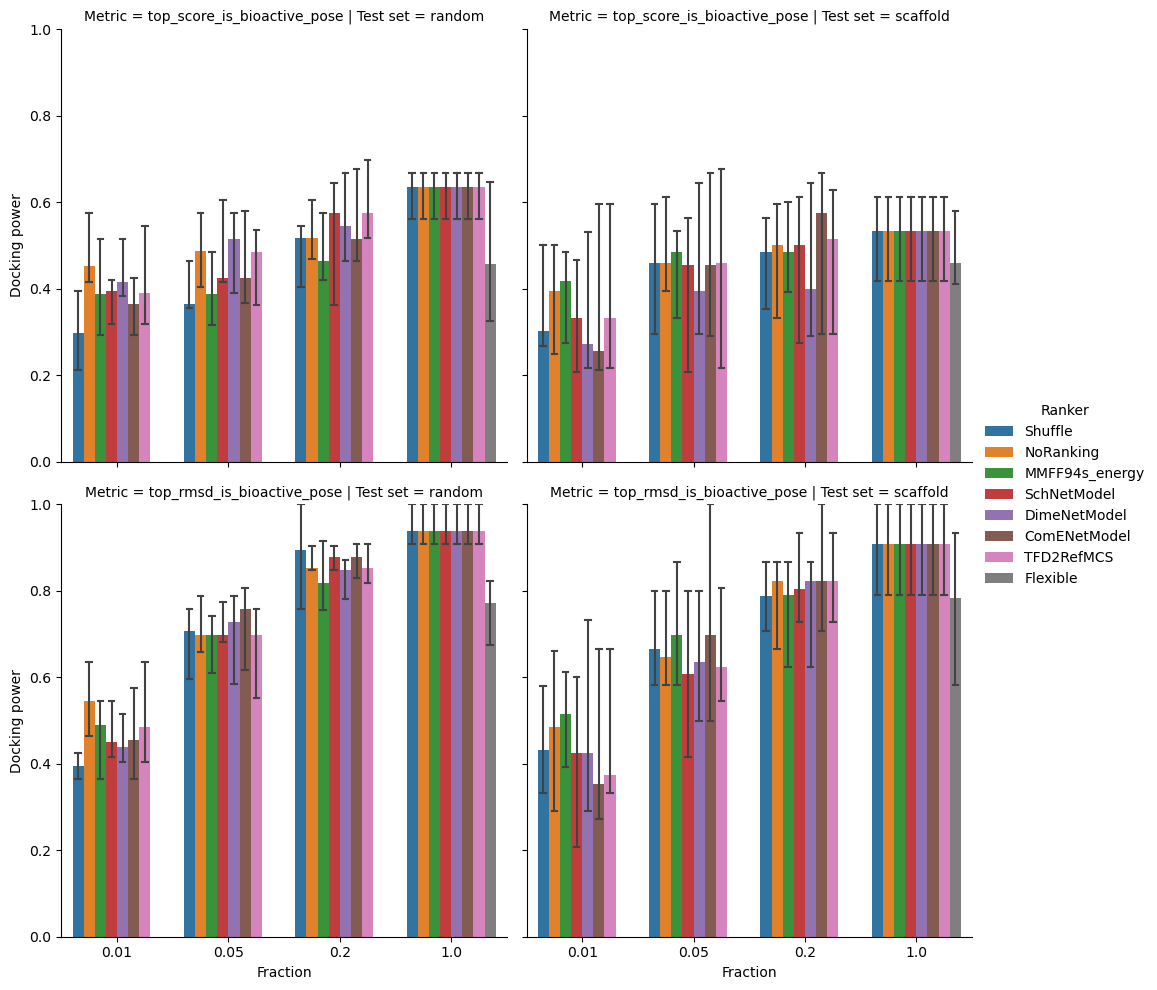

2.4.2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1394/1394 [00:00<00:00, 186449.18it/s]


Reading files


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1311/1311 [00:00<00:00, 171049.63it/s]


Reading files


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1438/1438 [00:00<00:00, 173540.76it/s]


Reading files


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1352/1352 [00:00<00:00, 177848.49it/s]


Reading files


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1350/1350 [00:00<00:00, 170110.87it/s]


Reading files


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1566/1566 [00:00<00:00, 177968.41it/s]


Reading files


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1264/1264 [00:00<00:00, 166131.87it/s]


Reading files


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1204/1204 [00:00<00:00, 166121.98it/s]


Reading files


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1319/1319 [00:00<00:00, 188147.43it/s]


Reading files


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1322/1322 [00:00<00:00, 172447.28it/s]


Reading files


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 1681.26it/s]


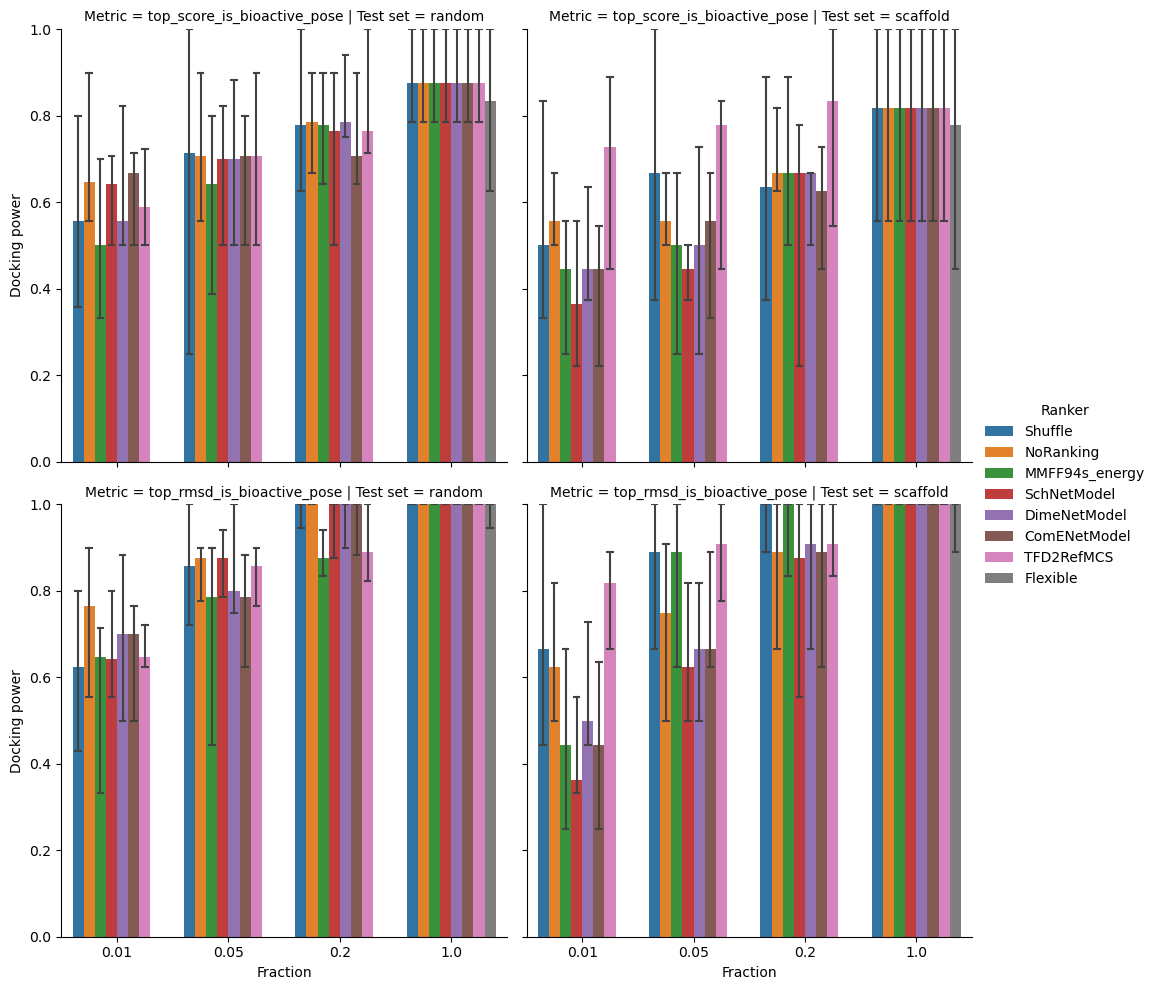

In [17]:
enzyme_classes = ['4.2.1', '2.4.2']
for enzyme_class in enzyme_classes:
    print(enzyme_class)
    uniprot_ids = pdbbind_df[pdbbind_df['level_3'] == enzyme_class]['Uniprot ID'].values
    df = pdbbind_analysis_for_uniprot_ids(uniprot_ids, only_good_docking=False)
    # df = pdbbind_analysis_for_uniprot_ids(uniprot_ids, only_good_docking=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1394/1394 [00:00<00:00, 23300.30it/s]


Reading files


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1311/1311 [00:00<00:00, 21797.19it/s]


Reading files


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1438/1438 [00:00<00:00, 22487.47it/s]


Reading files


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1352/1352 [00:00<00:00, 22890.55it/s]


Reading files


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1350/1350 [00:00<00:00, 21189.22it/s]


Reading files


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1566/1566 [00:00<00:00, 22083.23it/s]


Reading files


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1264/1264 [00:00<00:00, 21548.33it/s]


Reading files


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1204/1204 [00:00<00:00, 21371.62it/s]


Reading files


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1319/1319 [00:00<00:00, 23591.84it/s]


Reading files


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1322/1322 [00:00<00:00, 22694.83it/s]


Reading files


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [00:00<00:00, 653.37it/s]


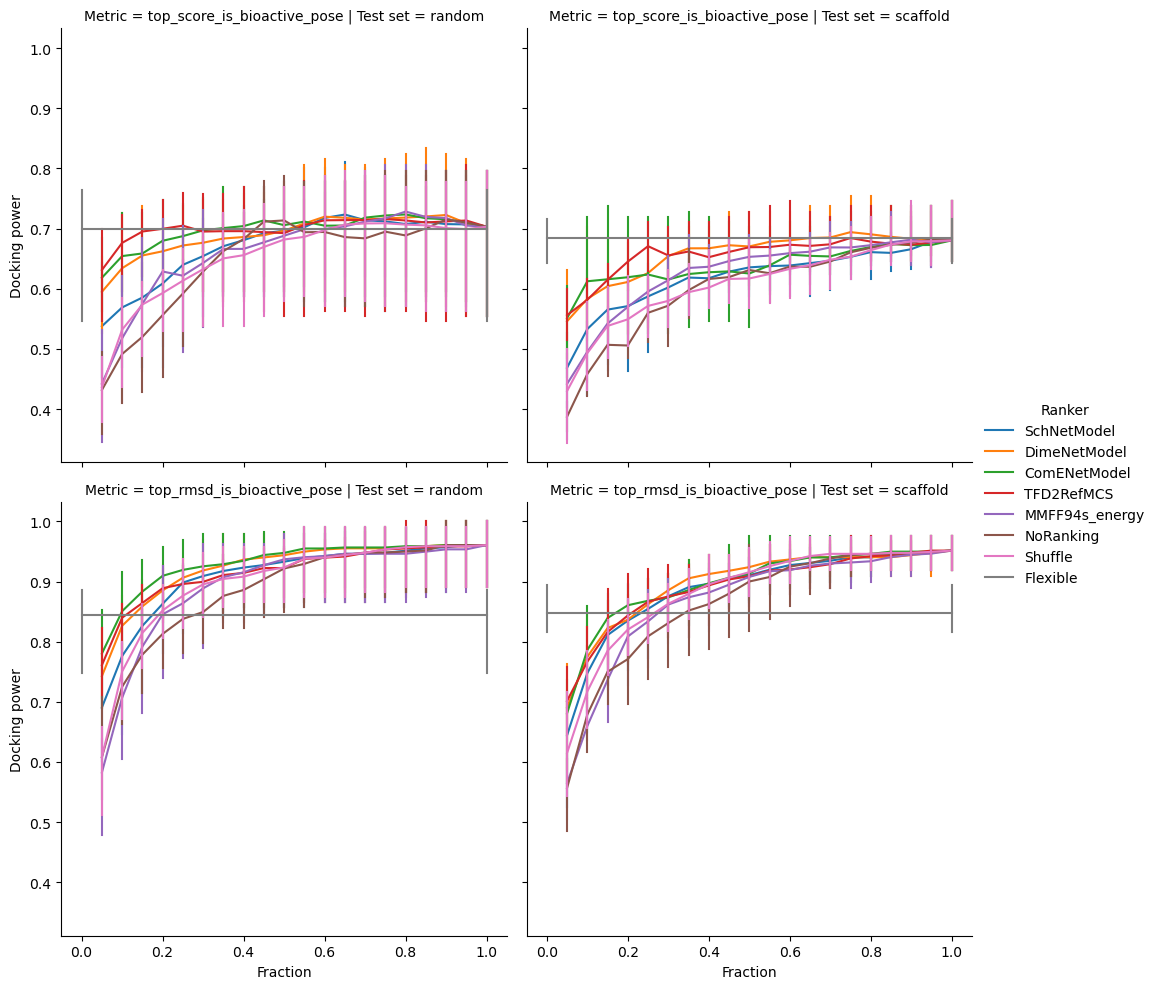

Test set  Iteration       Ranker                       Metric  Fraction  \
0      random          0  SchNetModel  top_score_is_bioactive_pose      0.01   
1      random          0  SchNetModel  top_score_is_bioactive_pose      0.02   
2      random          0  SchNetModel  top_score_is_bioactive_pose      0.03   
3      random          0  SchNetModel  top_score_is_bioactive_pose      0.04   
4      random          0  SchNetModel  top_score_is_bioactive_pose      0.05   
..        ...        ...          ...                          ...       ...   
697  scaffold          4      Shuffle   top_rmsd_is_bioactive_pose      0.98   
698  scaffold          4      Shuffle   top_rmsd_is_bioactive_pose      0.99   
699  scaffold          4      Shuffle   top_rmsd_is_bioactive_pose      1.00   
700  scaffold          4     Flexible   top_rmsd_is_bioactive_pose      0.00   
701  scaffold          4     Flexible   top_rmsd_is_bioactive_pose      1.00   

     Docking power  
0         0.416667  
1         0.425926  
2         0.444444  
3         0.472222  
4         0.453704  
..             ...  
697       0.976000  
698       0.976000  
699       0.976000  
700       0.816000  
701       0.816000  

[14040 rows x 6 columns]

In [117]:
uniprot_ids = pdbbind_df[pdbbind_df['level_3'] == '3.4.23']['Uniprot ID'].values
df = pdbbind_analysis_for_uniprot_ids(uniprot_ids, only_good_docking=False)

In [ ]:
uniprot_ids = pdbbind_df[pdbbind_df['level_2'] == '3.4.23']['Uniprot ID'].values
df = pdbbind_analysis_for_uniprot_ids(uniprot_ids, only_good_docking=False)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1394/1394 [00:00<00:00, 13226.18it/s]


Reading files


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1311/1311 [00:00<00:00, 11976.44it/s]


Reading files


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1438/1438 [00:00<00:00, 12444.67it/s]


Reading files


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1352/1352 [00:00<00:00, 12598.67it/s]


Reading files


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1350/1350 [00:00<00:00, 12150.28it/s]


Reading files


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1566/1566 [00:00<00:00, 12819.21it/s]


Reading files


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1264/1264 [00:00<00:00, 11858.94it/s]


Reading files


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1204/1204 [00:00<00:00, 11739.49it/s]


Reading files


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1319/1319 [00:00<00:00, 13421.30it/s]


Reading files


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1322/1322 [00:00<00:00, 12636.76it/s]


Reading files


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 312/312 [00:00<00:00, 777.90it/s]


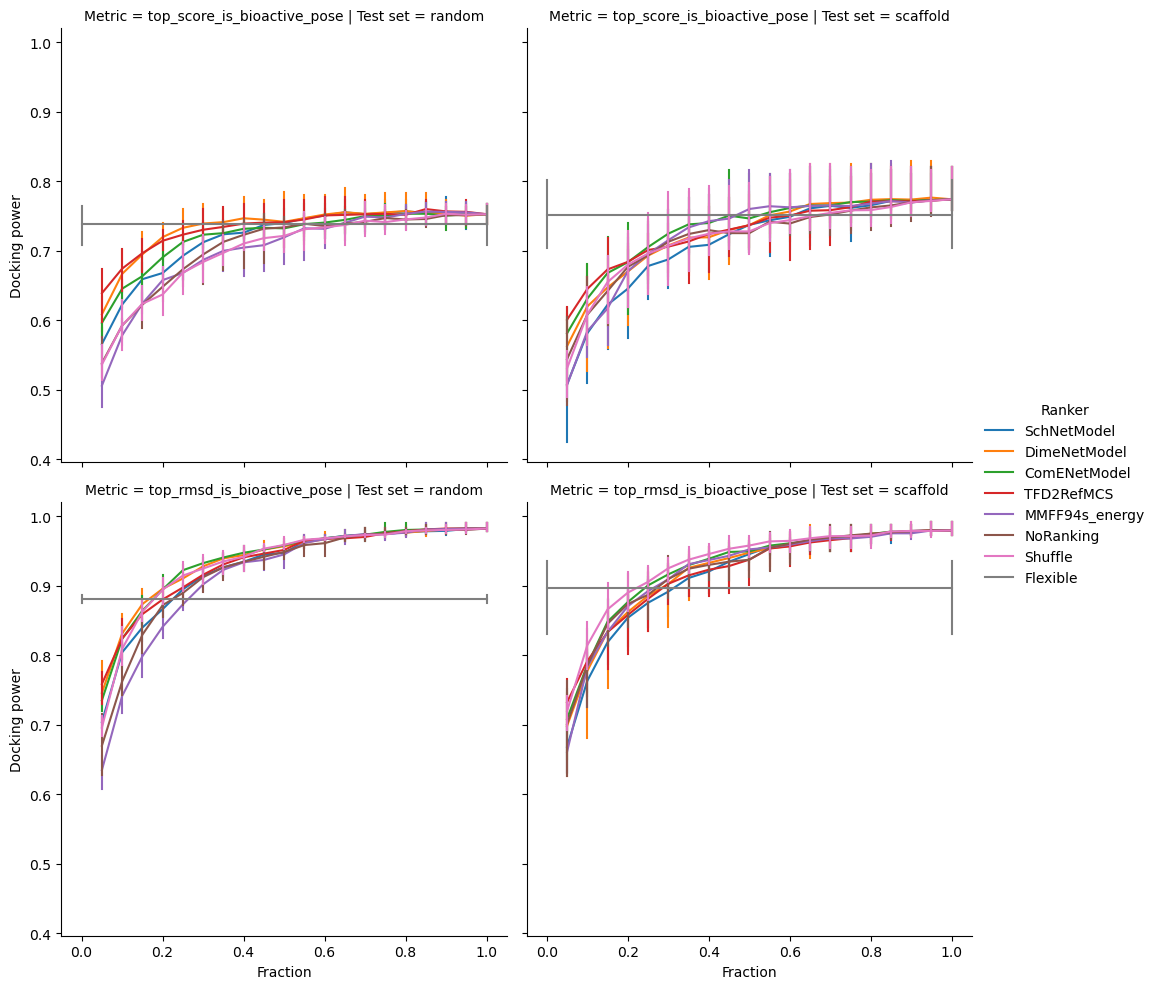

Test set  Iteration       Ranker                       Metric  Fraction  \
0      random          0  SchNetModel  top_score_is_bioactive_pose      0.01   
1      random          0  SchNetModel  top_score_is_bioactive_pose      0.02   
2      random          0  SchNetModel  top_score_is_bioactive_pose      0.03   
3      random          0  SchNetModel  top_score_is_bioactive_pose      0.04   
4      random          0  SchNetModel  top_score_is_bioactive_pose      0.05   
..        ...        ...          ...                          ...       ...   
697  scaffold          4      Shuffle   top_rmsd_is_bioactive_pose      0.98   
698  scaffold          4      Shuffle   top_rmsd_is_bioactive_pose      0.99   
699  scaffold          4      Shuffle   top_rmsd_is_bioactive_pose      1.00   
700  scaffold          4     Flexible   top_rmsd_is_bioactive_pose      0.00   
701  scaffold          4     Flexible   top_rmsd_is_bioactive_pose      1.00   

     Docking power  
0         0.422297  
1         0.452703  
2         0.503378  
3         0.537162  
4         0.550676  
..             ...  
697       0.986842  
698       0.986842  
699       0.986842  
700       0.921053  
701       0.921053  

[14040 rows x 6 columns]

In [118]:
uniprot_ids = pdbbind_df[pdbbind_df['level_1'] == '2']['Uniprot ID'].values
pdbbind_analysis_for_uniprot_ids(uniprot_ids, only_good_docking=False)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1394/1394 [00:00<00:00, 17134.51it/s]


Reading files


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1311/1311 [00:00<00:00, 15434.39it/s]


Reading files


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1438/1438 [00:00<00:00, 16364.31it/s]


Reading files


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1352/1352 [00:00<00:00, 16011.91it/s]


Reading files


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1350/1350 [00:00<00:00, 16029.55it/s]


Reading files


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1566/1566 [00:00<00:00, 16745.99it/s]


Reading files


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1264/1264 [00:00<00:00, 15885.37it/s]


Reading files


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1204/1204 [00:00<00:00, 15506.74it/s]


Reading files


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1319/1319 [00:00<00:00, 17496.11it/s]


Reading files


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1322/1322 [00:00<00:00, 15961.01it/s]


Reading files


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 241/241 [00:00<00:00, 683.34it/s]


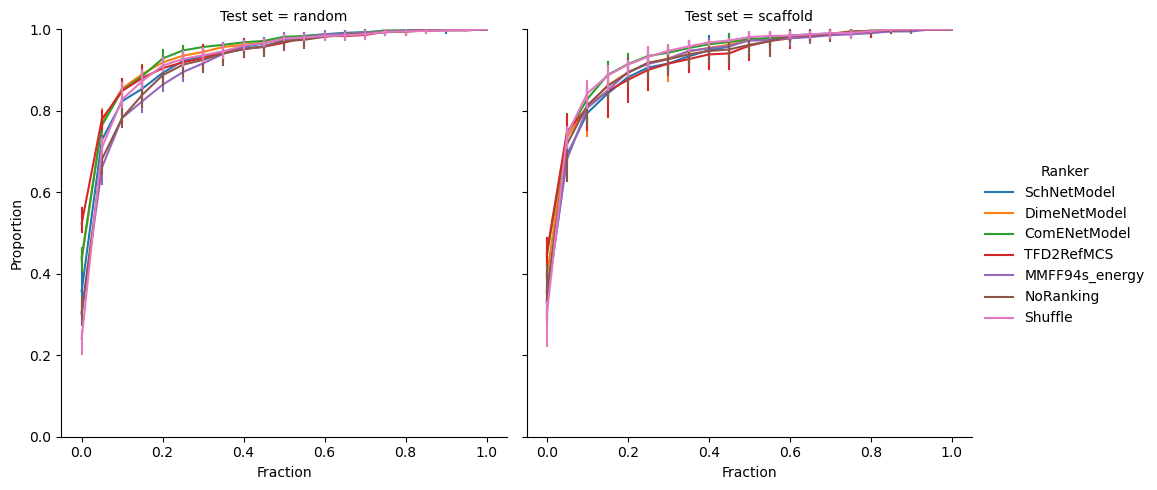

In [125]:
uniprot_ids = pdbbind_df[pdbbind_df['level_2'] == '2.7']['Uniprot ID'].values
pdbbind_analysis_for_uniprot_ids(uniprot_ids, only_good_docking=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1394/1394 [00:00<00:00, 46575.53it/s]


Reading files


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1311/1311 [00:00<00:00, 41541.25it/s]


Reading files


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1438/1438 [00:00<00:00, 42087.92it/s]


Reading files


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1352/1352 [00:00<00:00, 42410.12it/s]


Reading files


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1350/1350 [00:00<00:00, 40070.13it/s]


Reading files


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1566/1566 [00:00<00:00, 42868.01it/s]


Reading files


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1264/1264 [00:00<00:00, 41906.90it/s]


Reading files


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1204/1204 [00:00<00:00, 41211.23it/s]


Reading files


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1319/1319 [00:00<00:00, 45796.32it/s]


Reading files


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1322/1322 [00:00<00:00, 43812.88it/s]


Reading files


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 129/129 [00:00<00:00, 636.27it/s]


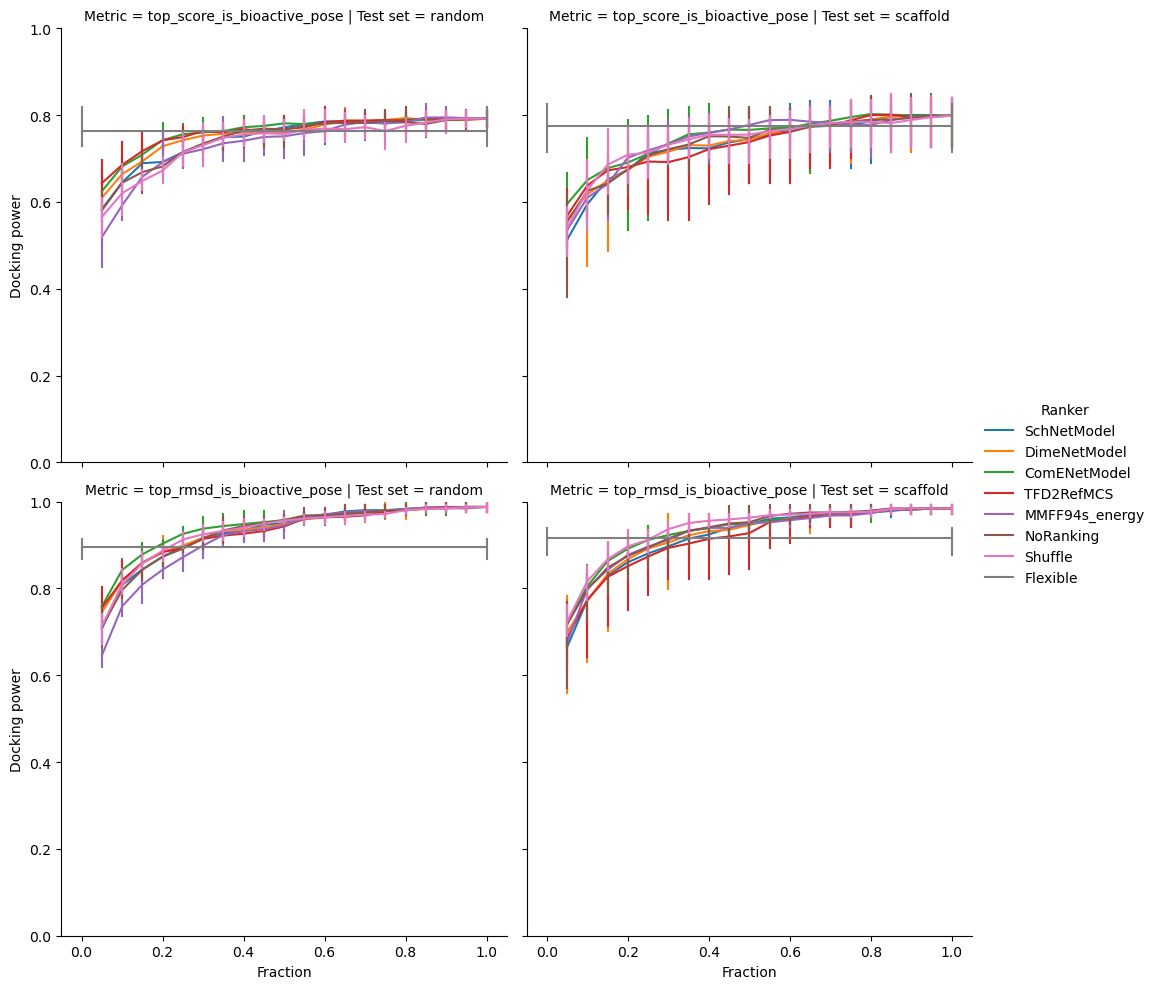

In [126]:
uniprot_ids = pdbbind_df[pdbbind_df['level_3'] == '2.7.11']['Uniprot ID'].values
pdbbind_analysis_for_uniprot_ids(uniprot_ids, only_good_docking=False)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1394/1394 [00:00<00:00, 97233.75it/s]


Reading files


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 1334.39it/s]


Flexible n_mols
68
Flexible docking power top score
0.7058823529411765
Flexible docking power top pose
0.8676470588235294
Flexible generation power
0.4411764705882353
Rigid n_mols
68
Rigid docking power top score
0.7058823529411765
Rigid docking power top pose
1.0
Rigid generation power
0.39705882352941174


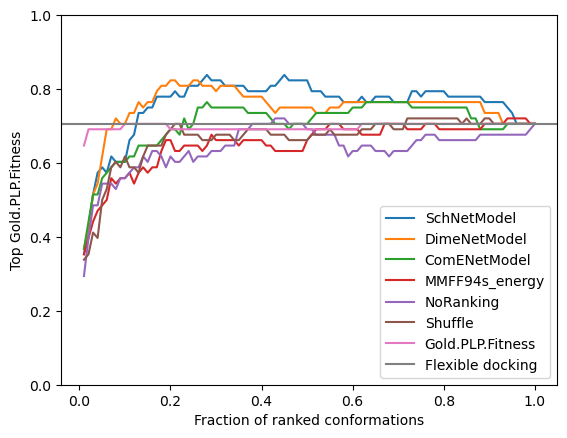

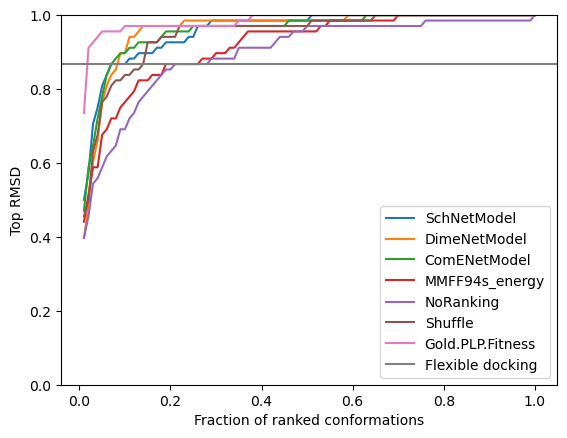

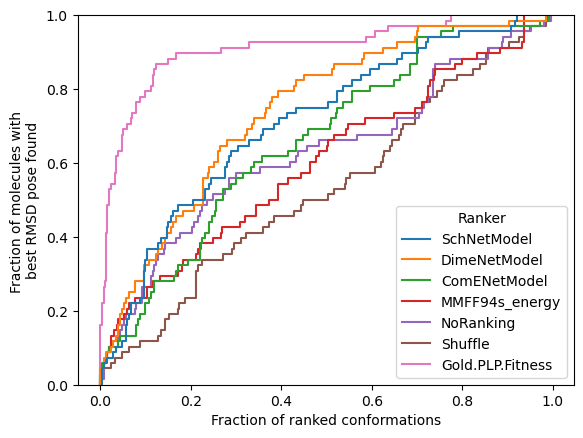

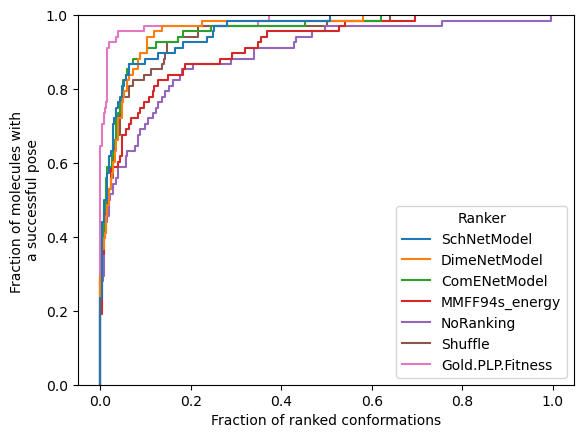

In [17]:
uniprot_ids = pdbbind_df[pdbbind_df['level_3'] == '2.7.10']['Uniprot ID'].values
pdbbind_analysis_for_uniprot_ids(uniprot_ids, split_is=[0], only_good_docking=False)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1394/1394 [00:00<00:00, 145191.45it/s]


Reading files


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 1504.75it/s]


Flexible n_mols
34
Flexible docking power top score
0.6764705882352942
Flexible docking power top pose
0.8235294117647058
Flexible generation power
0.47058823529411764
Rigid n_mols
34
Rigid docking power top score
0.7058823529411765
Rigid docking power top pose
1.0
Rigid generation power
0.5


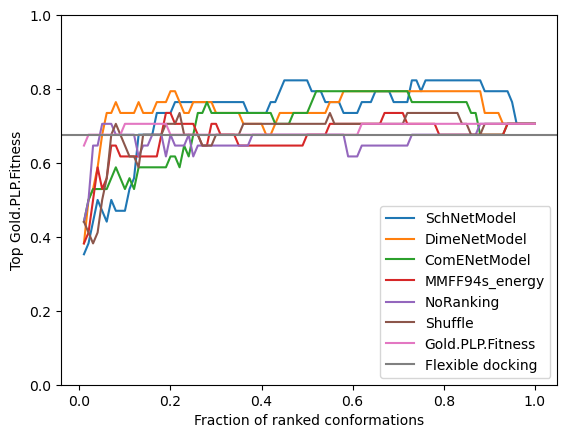

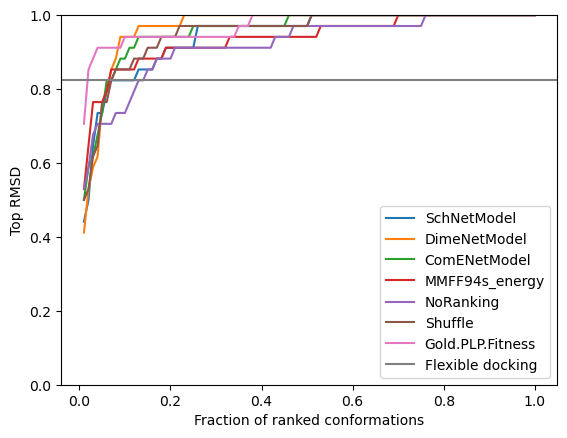

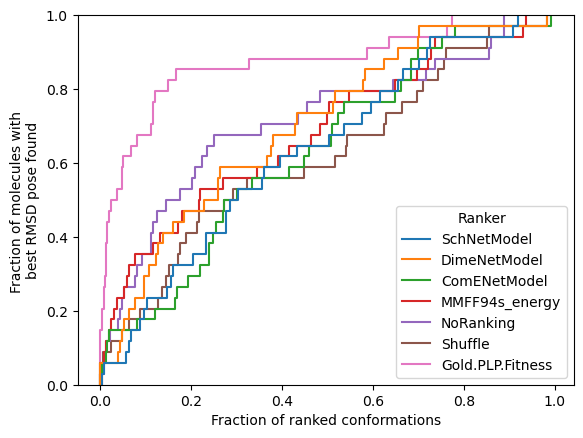

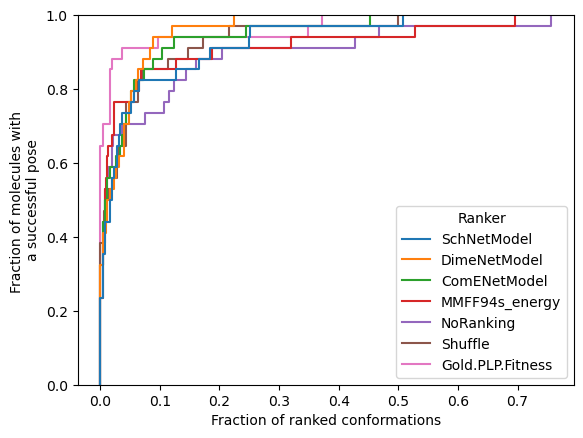

In [18]:
uniprot_ids = pdbbind_df[pdbbind_df['level_4'] == '2.7.10.2']['Uniprot ID'].values
pdbbind_analysis_for_uniprot_ids(uniprot_ids, split_is=[0], only_good_docking=False)

100%|████████████████████████████████████| 1394/1394 [00:00<00:00, 13602.00it/s]


Reading files


100%|███████████████████████████████████████| 297/297 [00:00<00:00, 2169.58it/s]


Flexible n_mols
291
Flexible docking power top score
0.7800687285223368
Flexible docking power top pose
0.8969072164948454
Flexible generation power
0.6907216494845361
Rigid n_mols
291
Rigid docking power top score
0.7800687285223368
Rigid docking power top pose
1.0
Rigid generation power
0.6872852233676976


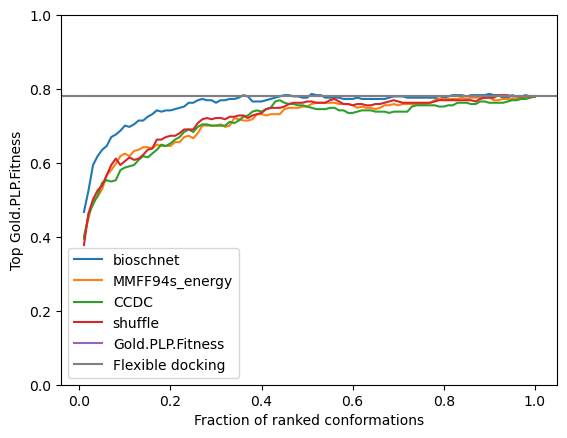

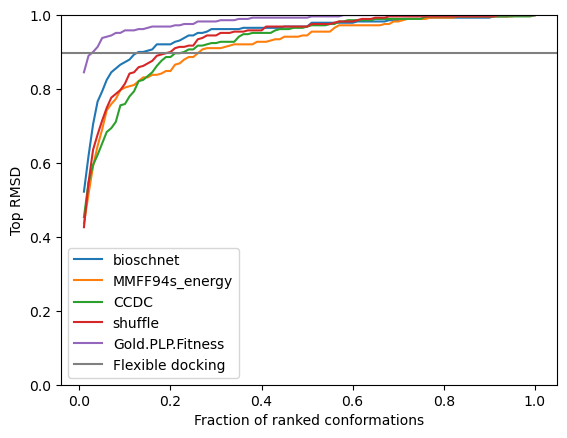

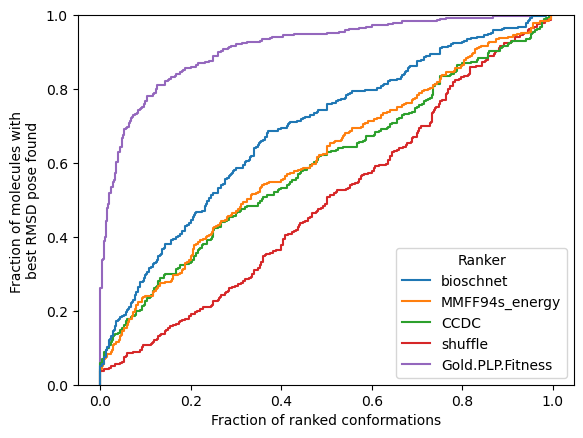

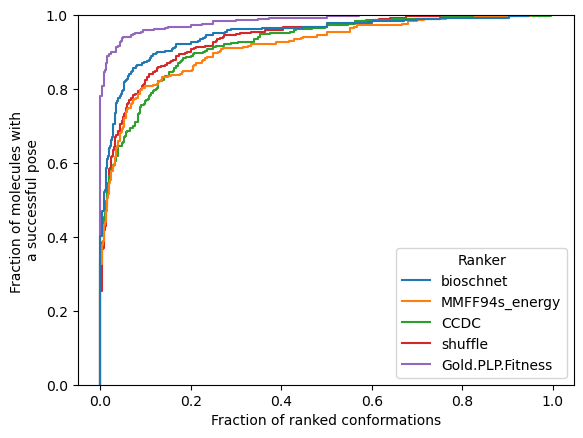

In [53]:
uniprot_ids = pdbbind_df[pdbbind_df['level_1'] == '2']['Uniprot ID'].values
pdbbind_analysis_for_uniprot_ids(uniprot_ids, split_is=[0])

In [5]:
pdbbind_df = pdbbind_df.merge(chembl_target_df, left_on='Uniprot ID', right_on='accession')

In [34]:
pdbbind_df[pdbbind_df['protein name'].str.contains('KINASE 2')].head(1)

PDB code resolution release year_x  -logKd/Ki             Kd/Ki  \
3806     2vtm       2.25           2008        3.0  IC50=1mM      //   

     reference ligand name activity_list sep      value units  release year_y  \
3806  2vta.pdf         LZM    [mM, =, 1]   =  1000000.0    nM            2008   

     Uniprot ID                    protein name  active accession  \
3806     P24941  CELL DIVISION PROTEIN KINASE 2   False    P24941   

     component_synonym                               protein_class_desc  \
3806              CDK2  enzyme  kinase  protein kinase  cmgc  cdk  cdc2   

      level1 gene_symbol_lowercase  
3806  enzyme                  cdk2

In [35]:
pdbbind_df[pdbbind_df['Uniprot ID'] == 'P24941'].head(3)

PDB code resolution release year_x  -logKd/Ki             Kd/Ki  \
3806     2vtm       2.25           2008       3.00  IC50=1mM      //   
3807     1wcc       2.20           2005       3.46  IC50=350uM    //   
3808     6q4e       1.06           2019       3.46  Kd=350uM      //   

     reference ligand name activity_list sep      value units  release year_y  \
3806  2vta.pdf         LZM    [mM, =, 1]   =  1000000.0    nM            2008   
3807  1wcc.pdf         CIG  [uM, =, 350]   =   350000.0    nM            2005   
3808  6q3b.pdf         HH5  [uM, =, 350]   =   350000.0    nM            2019   

     Uniprot ID                    protein name  active accession  \
3806     P24941  CELL DIVISION PROTEIN KINASE 2   False    P24941   
3807     P24941  CELL DIVISION PROTEIN KINASE 2   False    P24941   
3808     P24941       CYCLIN-DEPENDENT KINASE 2   False    P24941   

     component_synonym                               protein_class_desc  \
3806              CDK2  enzyme  kinase  protein kinase  cmgc  cdk  cdc2   
3807              CDK2  enzyme  kinase  protein kinase  cmgc  cdk  cdc2   
3808              CDK2  enzyme  kinase  protein kinase  cmgc  cdk  cdc2   

      level1 gene_symbol_lowercase  
3806  enzyme                  cdk2  
3807  enzyme                  cdk2  
3808  enzyme                  cdk2

In [8]:
pdbbind_df[pdbbind_df['protein name'].str.contains('SECRETASE')].head()

PDB code resolution release year_x  -logKd/Ki             Kd/Ki  \
2402     4zsm       1.96           2015       2.40  IC50~4mM      //   
2403     2ohk       2.20           2007       2.70  IC50~2000uM   //   
2404     3bra       2.30           2008       2.70  Kd=2000uM     //   
2405     3hvg       2.26           2009       2.70  IC50=2mM      //   
2406     3udh       1.70           2012       2.85  Kd=1.4mM      //   

     reference ligand name  activity_list sep      value units  \
2402  4zsm.pdf         4RW     [mM, ~, 4]   ~  4000000.0    nM   
2403  2ohk.pdf         1SQ  [uM, ~, 2000]   ~  2000000.0    nM   
2404  3bra.pdf         AEF  [uM, =, 2000]   =  2000000.0    nM   
2405  3hvg.pdf         EV0     [mM, =, 2]   =  2000000.0    nM   
2406  3udh.pdf         091   [mM, =, 1.4]   =  1400000.0    nM   

      release year_y Uniprot ID      protein name  active accession  \
2402            2015     P56817  BETA-SECRETASE 1   False    P56817   
2403            2007     P56817  BETA-SECRETASE 1   False    P56817   
2404            2008     P56817  BETA-SECRETASE 1   False    P56817   
2405            2009     P56817  BETA-SECRETASE 1   False    P56817   
2406            2012     P56817  BETA-SECRETASE 1   False    P56817   

     component_synonym                   protein_class_desc  level1  \
2402             BACE1  enzyme  protease  aspartic  aa  a1a  enzyme   
2403             BACE1  enzyme  protease  aspartic  aa  a1a  enzyme   
2404             BACE1  enzyme  protease  aspartic  aa  a1a  enzyme   
2405             BACE1  enzyme  protease  aspartic  aa  a1a  enzyme   
2406             BACE1  enzyme  protease  aspartic  aa  a1a  enzyme   

     gene_symbol_lowercase  
2402                 bace1  
2403                 bace1  
2404                 bace1  
2405                 bace1  
2406                 bace1

In [9]:
pdbbind_df[pdbbind_df['protein name'].str.contains('ANHYDRASE')].head()

PDB code resolution release year_x  -logKd/Ki             Kd/Ki reference  \
18     1zsb       2.00           1996       0.60  Kd=250mM      //  1zsb.pdf   
19     4e4a       1.45           2012       2.05  IC50=9mM      //  4e3d.pdf   
20     4q90       1.54           2015       2.15  Ki=7.0mM      //  4q7p.pdf   
21     5fnj       1.67           2016       2.29  Kd=5150uM     //  5eh5.pdf   
22     4e3d       1.60           2012       2.30  IC50=5mM      //  4e3d.pdf   

   ligand name  activity_list sep        value units  release year_y  \
18         AZM   [mM, =, 250]   =  250000000.0    nM            1996   
19         JKE     [mM, =, 9]   =    9000000.0    nM            2012   
20         4H2   [mM, =, 7.0]   =    7000000.0    nM            2015   
21         YI6  [uM, =, 5150]   =    5150000.0    nM            2016   
22         GTQ     [mM, =, 5]   =    5000000.0    nM            2012   

   Uniprot ID          protein name  active accession component_synonym  \
18     P00918  CARBONIC ANHYDRASE 2   False    P00918               CA2   
19     P00918  CARBONIC ANHYDRASE 2   False    P00918               CA2   
20     P00918  CARBONIC ANHYDRASE 2   False    P00918               CA2   
21     P00918  CARBONIC ANHYDRASE 2   False    P00918               CA2   
22     P00918  CARBONIC ANHYDRASE 2   False    P00918               CA2   

   protein_class_desc  level1 gene_symbol_lowercase  
18      enzyme  lyase  enzyme                   ca2  
19      enzyme  lyase  enzyme                   ca2  
20      enzyme  lyase  enzyme                   ca2  
21      enzyme  lyase  enzyme                   ca2  
22      enzyme  lyase  enzyme                   ca2

In [10]:
pdbbind_df[pdbbind_df['protein name'].str.contains('JAK')].head()

PDB code resolution release year_x  -logKd/Ki             Kd/Ki  \
7369     5ut6       1.65           2017       4.24  Kd=57.3uM     //   
7370     5ut6       1.65           2017       4.24  Kd=57.3uM     //   
7371     5ut4       2.00           2017       4.38  Kd=42uM       //   
7372     5ut4       2.00           2017       4.38  Kd=42uM       //   
7373     3e62       1.92           2008       4.39  IC50=40.9uM   //   

     reference ligand name  activity_list sep    value units  release year_y  \
7369  5ut4.pdf         8MY  [uM, =, 57.3]   =  57300.0    nM            2017   
7370  5ut4.pdf         8MY  [uM, =, 57.3]   =  57300.0    nM            2017   
7371  5ut4.pdf         DQX    [uM, =, 42]   =  42000.0    nM            2017   
7372  5ut4.pdf         DQX    [uM, =, 42]   =  42000.0    nM            2017   
7373  3e62.pdf         5B1  [uM, =, 40.9]   =  40900.0    nM            2008   

     Uniprot ID                  protein name  active accession  \
7369     O60674  TYROSINE-PROTEIN KINASE JAK2   False    O60674   
7370     O60674  TYROSINE-PROTEIN KINASE JAK2   False    O60674   
7371     O60674  TYROSINE-PROTEIN KINASE JAK2   False    O60674   
7372     O60674  TYROSINE-PROTEIN KINASE JAK2   False    O60674   
7373     O60674  TYROSINE-PROTEIN KINASE JAK2   False    O60674   

     component_synonym                        protein_class_desc  level1  \
7369              JAK2  enzyme  kinase  protein kinase  tk  jaka  enzyme   
7370              JAK2  enzyme  kinase  protein kinase  tk  jakb  enzyme   
7371              JAK2  enzyme  kinase  protein kinase  tk  jaka  enzyme   
7372              JAK2  enzyme  kinase  protein kinase  tk  jakb  enzyme   
7373              JAK2  enzyme  kinase  protein kinase  tk  jaka  enzyme   

     gene_symbol_lowercase  
7369                  jak2  
7370                  jak2  
7371                  jak2  
7372                  jak2  
7373                  jak2

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1394/1394 [00:00<00:00, 11825.43it/s]


Reading files


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 479/479 [00:00<00:00, 2163.84it/s]


Flexible n_mols
467
Flexible docking power top score
0.6937901498929336
Flexible docking power top pose
0.854389721627409
Flexible generation power
0.6252676659528907
Rigid n_mols
467
Rigid docking power top score
0.7366167023554604
Rigid docking power top pose
1.0
Rigid generation power
0.6295503211991434


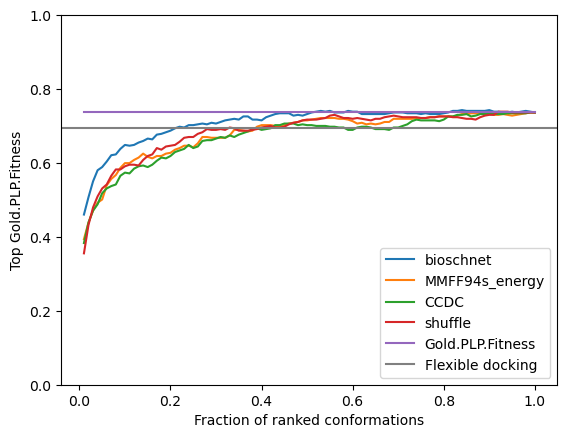

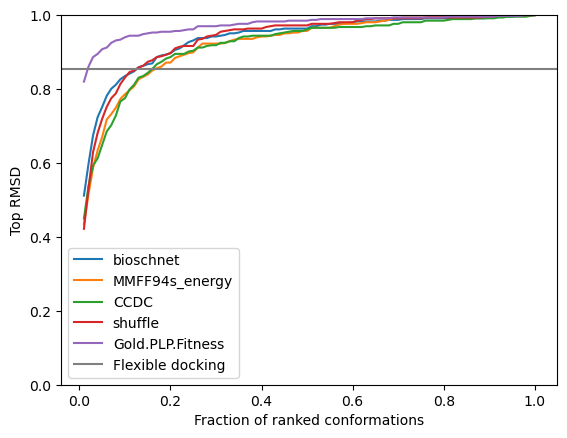

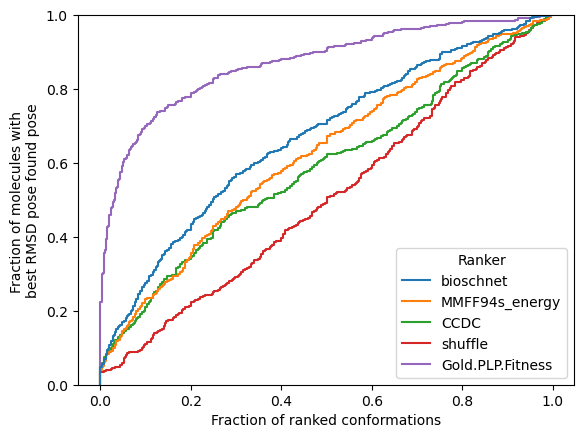

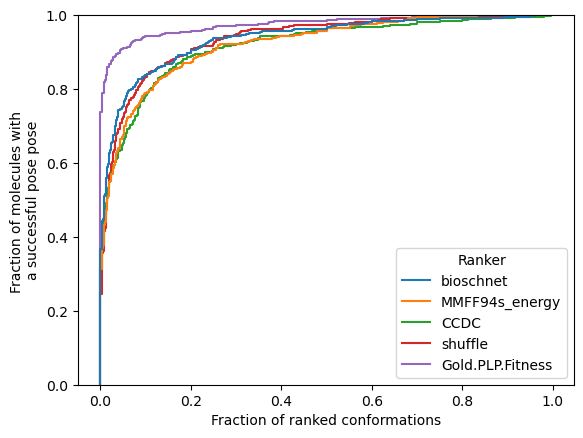

In [44]:
enzyme_uniprot_ids = pdbbind_df[pdbbind_df[level_str] == 'enzyme']['Uniprot ID'].unique()
pdbbind_analysis_for_uniprot_ids(enzyme_uniprot_ids)

In [6]:
pdbbind_df = pmp.get_master_dataframe()
level = 2
level_str = f'level{level}'
chembl_target_df = cc.get_target_table(level=level)
chembl_target_df.head()

accession component_synonym                  protein_class_desc  \
0    O09028             Gabrp            ion channel  lgic  gabaa   
1    P02708            CHRNA1  ion channel  lgic  ach  chrn alpha   
2    P04637              TP53                transcription factor   
3    P04757            Chrna3  ion channel  lgic  ach  chrn alpha   
4    P05106             ITGB3                   membrane receptor   

                 level2 gene_symbol_lowercase  
0     ion channel  lgic                 gabrp  
1     ion channel  lgic                chrna1  
2  transcription factor                  tp53  
3     ion channel  lgic                chrna3  
4     membrane receptor                 itgb3

In [7]:
chembl_target_df['level2'].unique()

array(['ion channel  lgic', 'transcription factor', 'membrane receptor',
       'enzyme  kinase', 'membrane receptor  7tm1', 'cytosolic other',
       'nuclear other', 'enzyme  phosphatase', 'enzyme  protease',
       'enzyme  cytochrome p450', 'enzyme  isomerase',
       'enzyme  transferase', 'secreted', 'membrane receptor  7tm2',
       'enzyme  hydrolase', 'enzyme  reductase', 'enzyme  lyase',
       'transporter  ntpase', 'adhesion', 'epigenetic regulator  eraser',
       'surface antigen', 'enzyme  phosphodiesterase',
       'transporter  electrochemical', 'ion channel  vgc', 'structural',
       'transcription factor  nuclear receptor',
       'membrane receptor  7tm3', 'enzyme',
       'auxiliary transport protein  ca alpha2delta', 'enzyme  ligase',
       'epigenetic regulator  reader', 'epigenetic regulator  writer',
       'membrane other', 'ion channel  other',
       'auxiliary transport protein  fabp',
       'transporter  group translocator', 'enzyme  aminoacyltransferas

In [8]:
pdbbind_df = pdbbind_df.merge(chembl_target_df, left_on='Uniprot ID', right_on='accession')

Loading results


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2952/2952 [00:01<00:00, 2330.26it/s]


Compiling metrics
Flexible n_mols
1063
Flexible docking power top score
0.7817497648165569
Flexible docking power top pose
0.9040451552210724
Flexible generation power
0.7187206020696143
Rigid n_mols
1063
Rigid docking power top score
0.8033866415804327
Rigid docking power top pose
1.0
Rigid generation power
0.7102539981185324


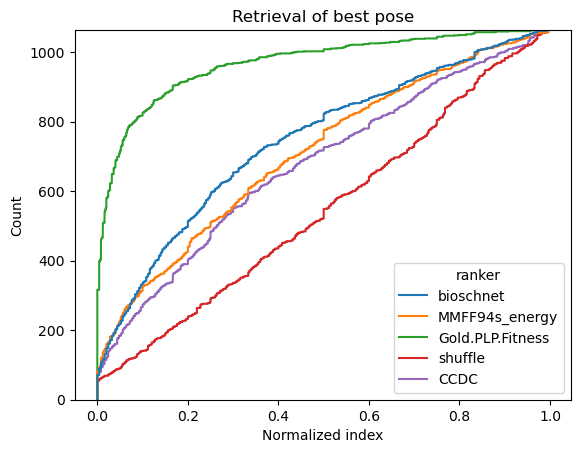

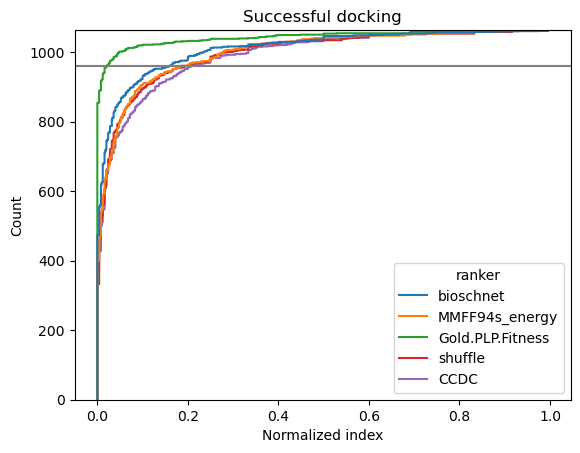

In [27]:
kinase_uniprot_ids = pdbbind_df[pdbbind_df[level_str] == 'enzyme  kinase']['Uniprot ID'].unique()
pdbbind_analysis_for_uniprot_ids(kinase_uniprot_ids)

Loading results


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2004/2004 [00:00<00:00, 2856.11it/s]


Compiling metrics
Flexible n_mols
444
Flexible docking power top score
0.7207207207207207
Flexible docking power top pose
0.8671171171171171
Flexible generation power
0.5495495495495496
Rigid n_mols
444
Rigid docking power top score
0.7274774774774775
Rigid docking power top pose
1.0
Rigid generation power
0.5833333333333334


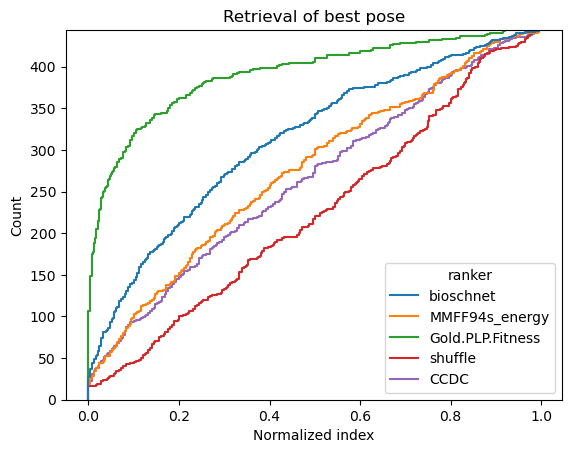

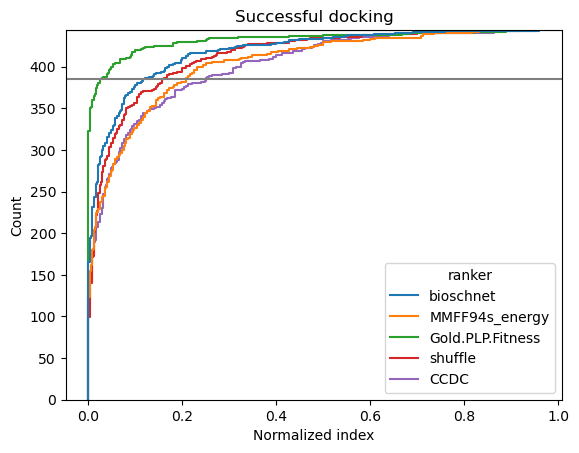

In [28]:
kinase_uniprot_ids = pdbbind_df[pdbbind_df[level_str] == 'enzyme  protease']['Uniprot ID'].unique()
pdbbind_analysis_for_uniprot_ids(kinase_uniprot_ids)

/home/bb596/anaconda3/envs/bioconfpred/lib/python3.7/site-packages/tqdm/auto/__init__.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.std.*` instead of `tqdm._tqdm.*`
  from .._tqdm import TqdmExperimentalWarning
/home/bb596/anaconda3/envs/bioconfpred/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from .._tqdm_notebook import tqdm_notebook as tqdm
100%|███████████████████████████████████| 1394/1394 [00:00<00:00, 223196.66it/s]


Reading files


100%|█████████████████████████████████████████| 17/17 [00:00<00:00, 1687.21it/s]


Flexible n_mols
17
Flexible docking power top score
0.8235294117647058
Flexible docking power top pose
0.9411764705882353
Flexible generation power
0.8235294117647058
Rigid n_mols
17
Rigid docking power top score
0.7058823529411765
Rigid docking power top pose
1.0
Rigid generation power
0.6470588235294118


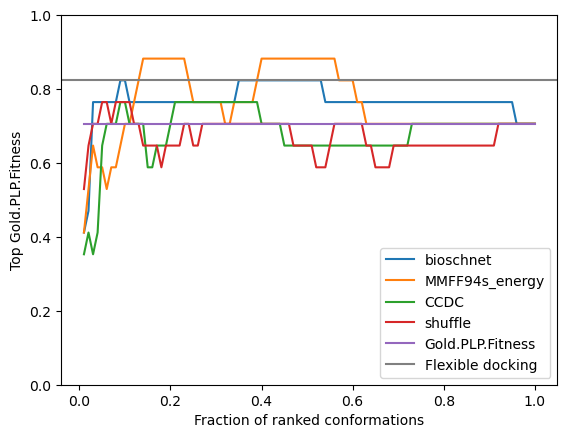

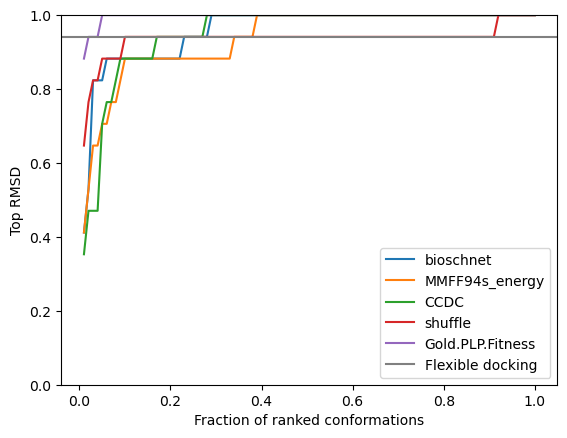

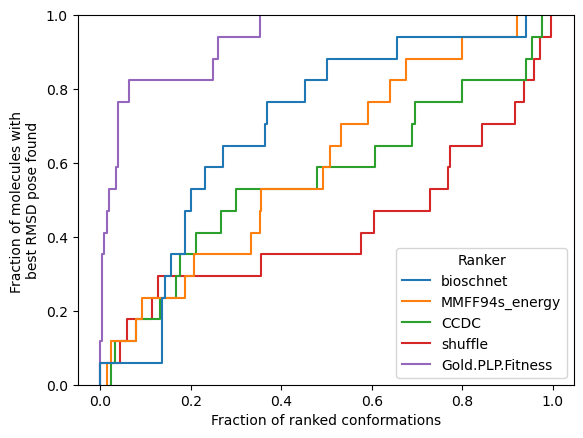

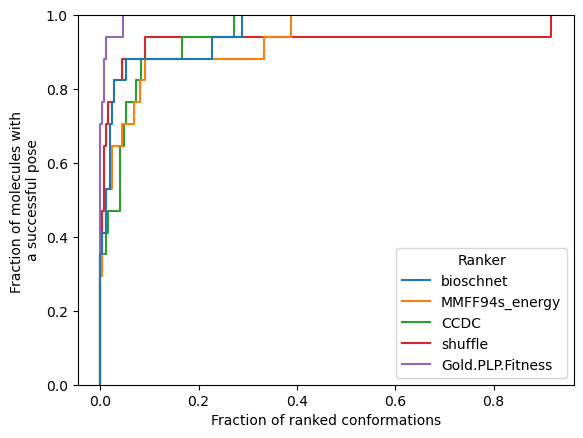

In [10]:
pdbbind_analysis_for_uniprot_ids(['P24941'],
                            only_good_docking=False) #CDK2

100%|███████████████████████████████████| 1394/1394 [00:00<00:00, 226561.00it/s]


Reading files


100%|███████████████████████████████████| 1311/1311 [00:00<00:00, 208025.29it/s]


Reading files


100%|███████████████████████████████████| 1438/1438 [00:00<00:00, 210873.69it/s]


Reading files


100%|███████████████████████████████████| 1352/1352 [00:00<00:00, 212616.66it/s]


Reading files


100%|███████████████████████████████████| 1350/1350 [00:00<00:00, 206465.28it/s]


Reading files


100%|█████████████████████████████████████████| 89/89 [00:00<00:00, 1820.38it/s]


Flexible n_mols
88
Flexible docking power top score
0.8068181818181818
Flexible docking power top pose
0.9431818181818182
Flexible generation power
0.6818181818181818
Rigid n_mols
88
Rigid docking power top score
0.8068181818181818
Rigid docking power top pose
1.0
Rigid generation power
0.6590909090909091


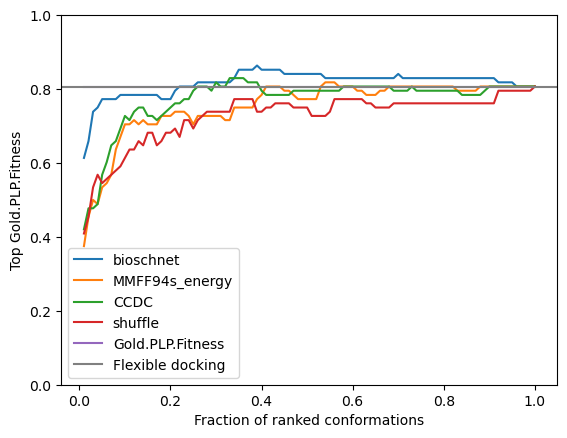

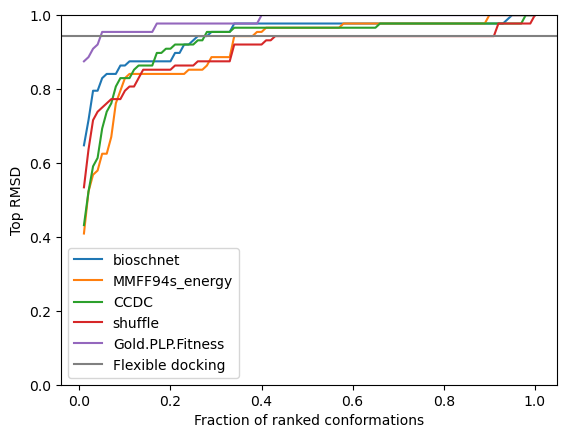

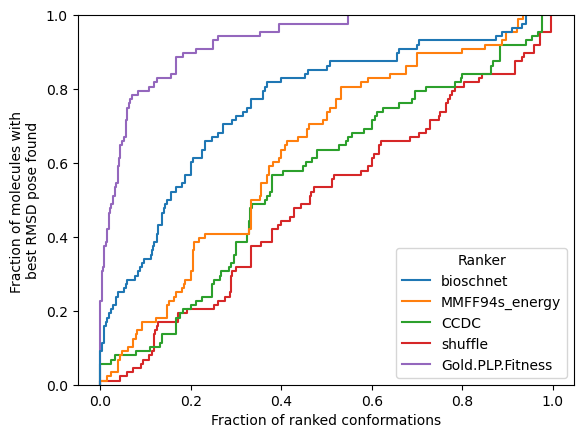

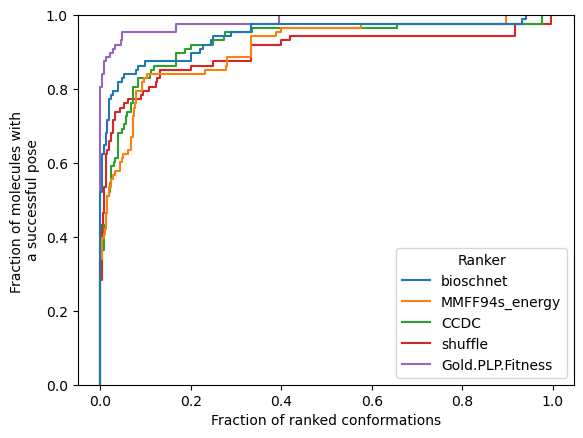

In [33]:
pdbbind_analysis_for_uniprot_ids(['P24941'])#CDK2

100%|███████████████████████████████████| 1350/1350 [00:00<00:00, 210073.10it/s]


Reading files


100%|█████████████████████████████████████████| 19/19 [00:00<00:00, 2249.40it/s]


Flexible n_mols
19
Flexible docking power top score
0.9473684210526315
Flexible docking power top pose
0.9473684210526315
Flexible generation power
0.5263157894736842
Rigid n_mols
19
Rigid docking power top score
0.7894736842105263
Rigid docking power top pose
1.0
Rigid generation power
0.47368421052631576


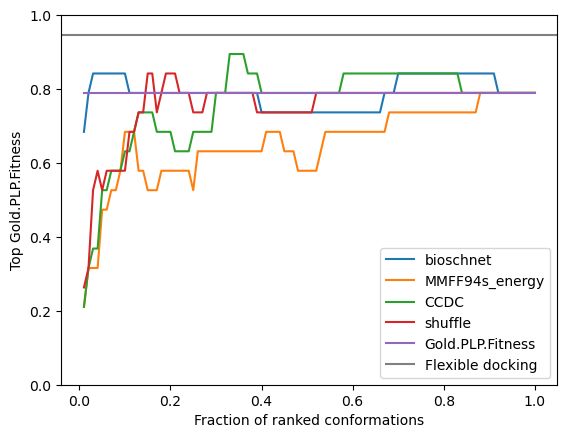

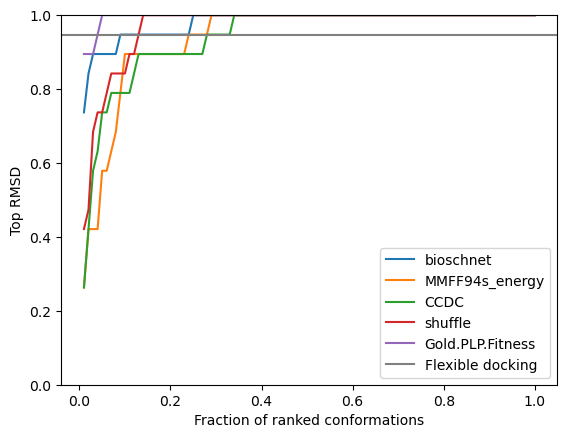

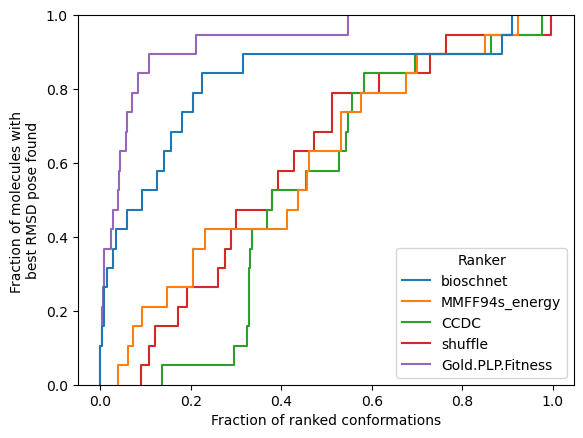

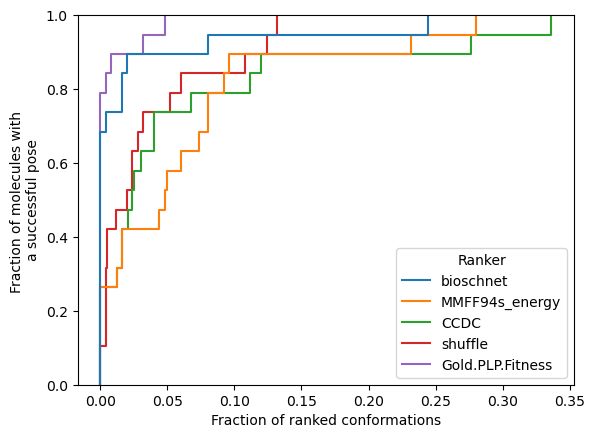

In [38]:
pdbbind_analysis_for_uniprot_ids(['P24941'], split_types=['random'], split_is=[4])

100%|███████████████████████████████████| 1394/1394 [00:00<00:00, 195547.15it/s]


Reading files


100%|█████████████████████████████████████████| 18/18 [00:00<00:00, 1924.53it/s]


Flexible n_mols
18
Flexible docking power top score
0.7777777777777778
Flexible docking power top pose
1.0
Flexible generation power
0.6666666666666666
Rigid n_mols
18
Rigid docking power top score
0.7222222222222222
Rigid docking power top pose
1.0
Rigid generation power
0.5555555555555556


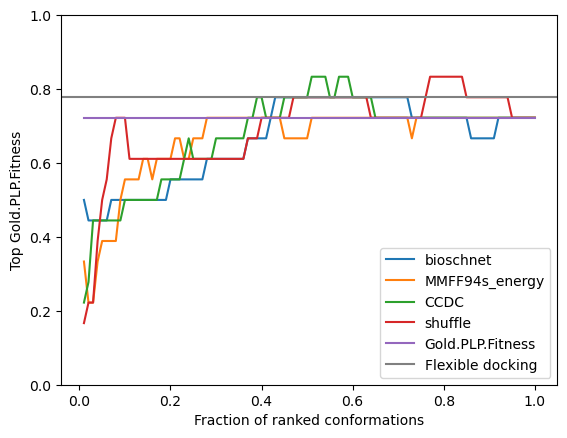

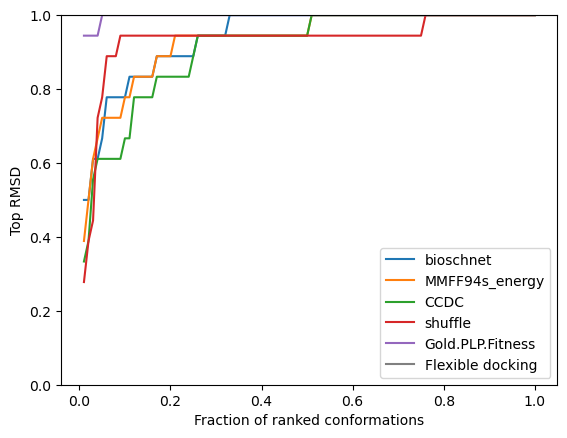

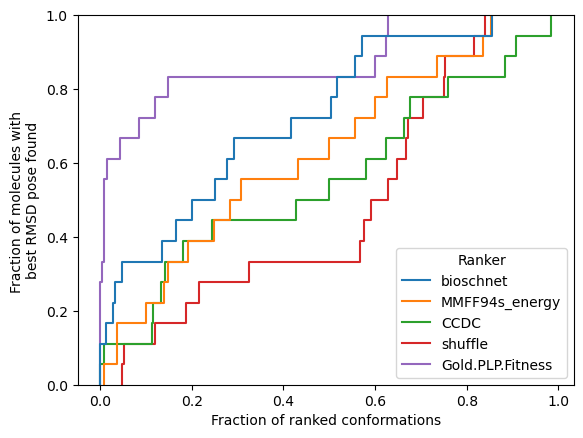

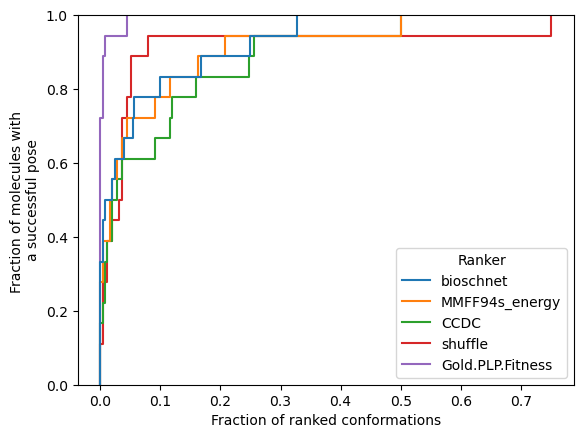

In [29]:
pdbbind_analysis_for_uniprot_ids(['P56817'],
                            only_good_docking=False) #BACE1

100%|███████████████████████████████████| 1394/1394 [00:00<00:00, 195973.18it/s]


Reading files


100%|███████████████████████████████████| 1311/1311 [00:00<00:00, 180315.87it/s]


Reading files


100%|███████████████████████████████████| 1438/1438 [00:00<00:00, 186719.37it/s]


Reading files


100%|███████████████████████████████████| 1352/1352 [00:00<00:00, 189592.08it/s]


Reading files


100%|███████████████████████████████████| 1350/1350 [00:00<00:00, 181008.58it/s]


Reading files


100%|█████████████████████████████████████████| 69/69 [00:00<00:00, 2014.19it/s]


Flexible n_mols
68
Flexible docking power top score
0.6911764705882353
Flexible docking power top pose
0.9264705882352942
Flexible generation power
0.5882352941176471
Rigid n_mols
68
Rigid docking power top score
0.7352941176470589
Rigid docking power top pose
1.0
Rigid generation power
0.6323529411764706


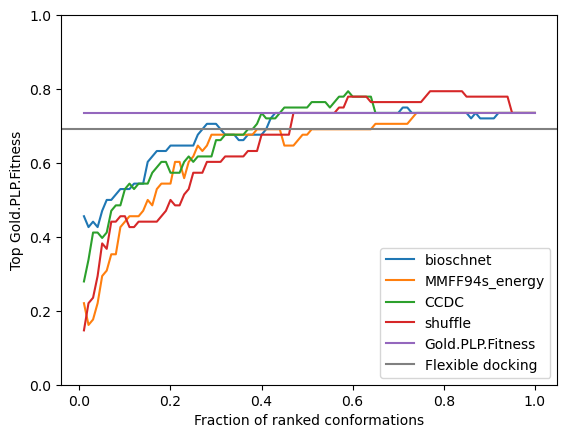

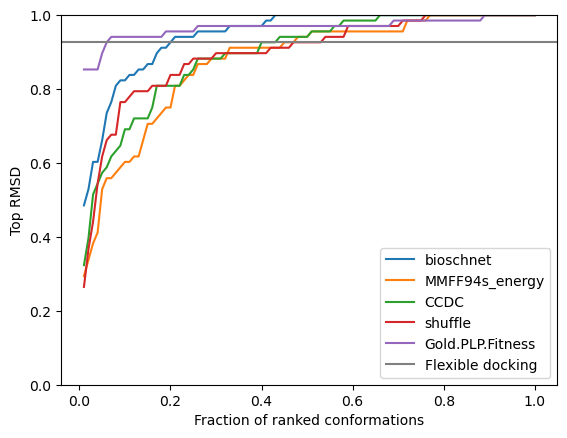

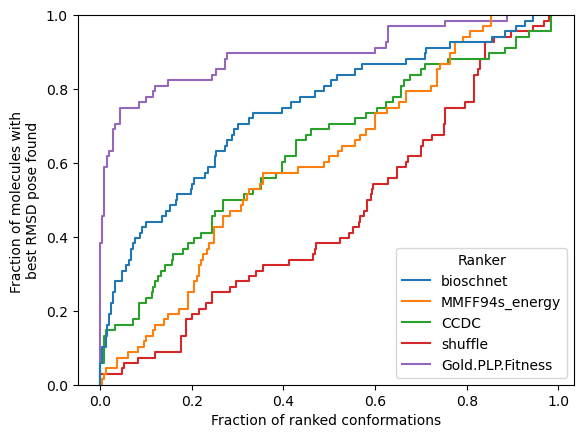

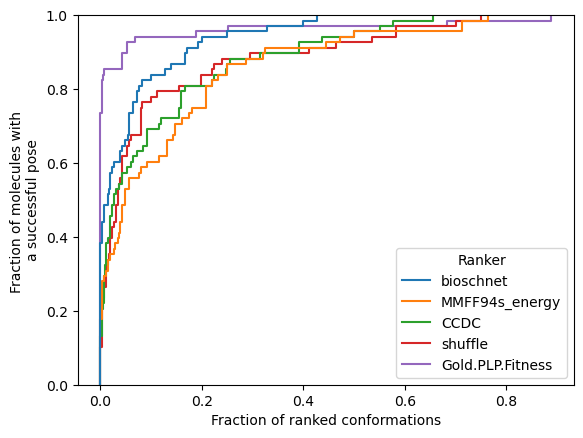

In [39]:
pdbbind_analysis_for_uniprot_ids(['P56817'])#BACE1

100%|███████████████████████████████████| 1350/1350 [00:00<00:00, 177791.71it/s]


Reading files


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 2135.92it/s]


Flexible n_mols
9
Flexible docking power top score
0.6666666666666666
Flexible docking power top pose
0.8888888888888888
Flexible generation power
0.5555555555555556
Rigid n_mols
9
Rigid docking power top score
0.5555555555555556
Rigid docking power top pose
1.0
Rigid generation power
0.5555555555555556


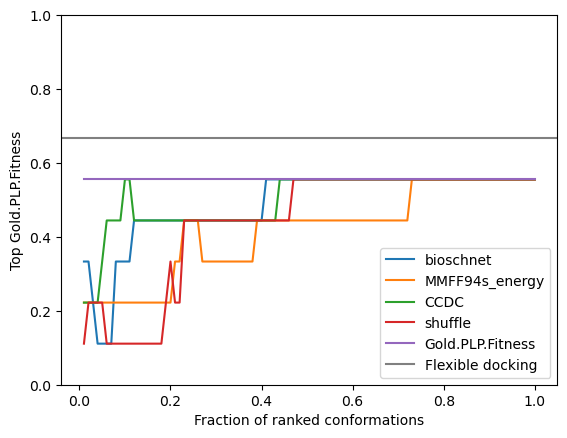

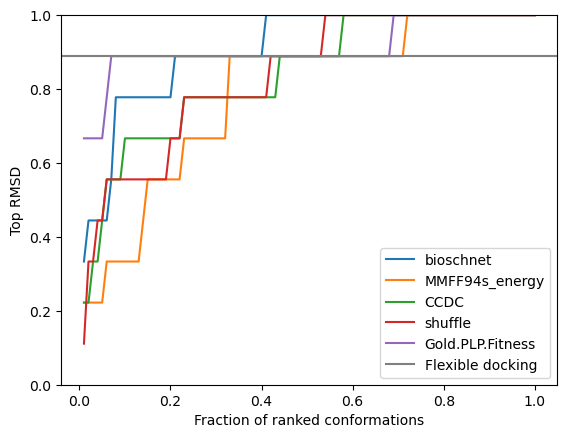

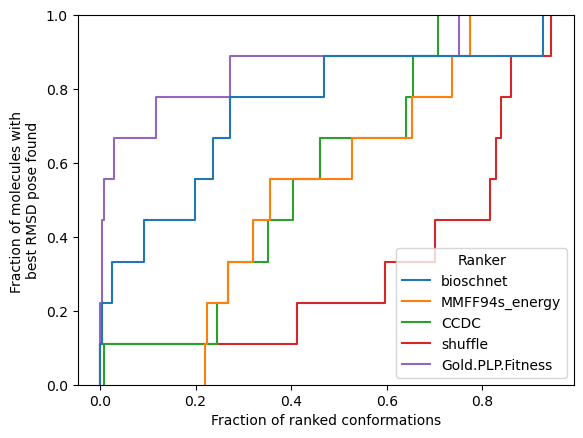

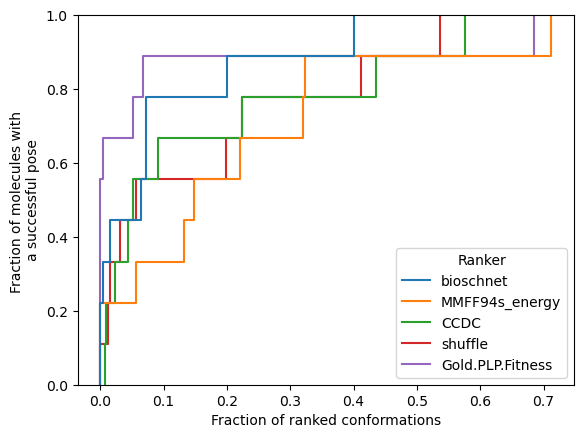

In [44]:
pdbbind_analysis_for_uniprot_ids(['P56817'], split_is=[4])#BACE1

Loading results


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 428/428 [00:00<00:00, 2098.52it/s]


Compiling metrics
Flexible n_mols
167
Flexible docking power top score
0.4550898203592814
Flexible docking power top pose
0.7904191616766467
Flexible generation power
0.5269461077844312
Rigid n_mols
167
Rigid docking power top score
0.562874251497006
Rigid docking power top pose
0.874251497005988
Rigid generation power
0.5748502994011976


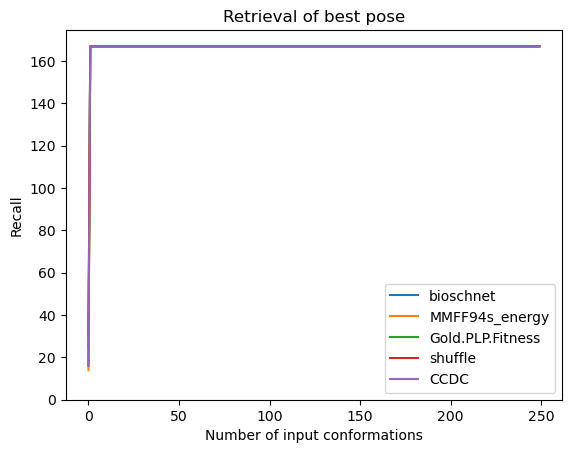

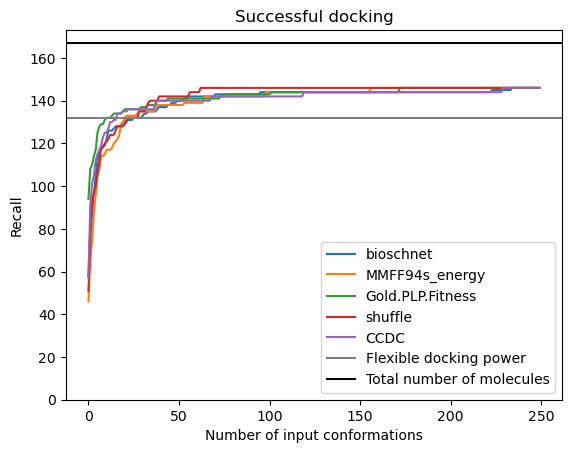

In [19]:
pdbbind_analysis_for_uniprot('P00918',
                            only_good_docking=False) #CA2

100%|█████████████████████████████████████| 179/179 [00:00<00:00, 127901.26it/s]

Loading results
Compiling metrics
Flexible n_mols
150
Flexible docking power top score
0.5
Flexible docking power top pose
0.8133333333333334
Flexible generation power
0.9666666666666667
Rigid generation power
0.9466666666666667
score
bioschnet
MMFF94s_energy
Gold.PLP.Fitness
shuffle
CCDC


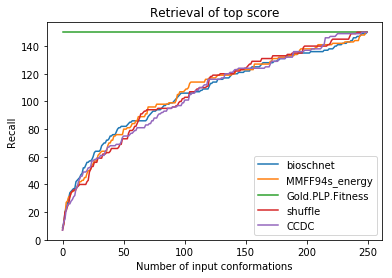

ligand_rmsd
bioschnet
MMFF94s_energy
Gold.PLP.Fitness
shuffle
CCDC


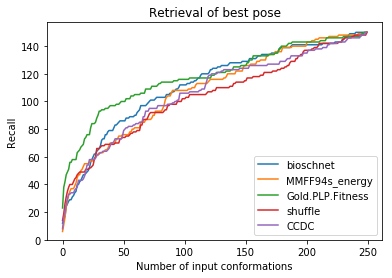

overlay_rmsd
bioschnet
MMFF94s_energy
Gold.PLP.Fitness
shuffle
CCDC


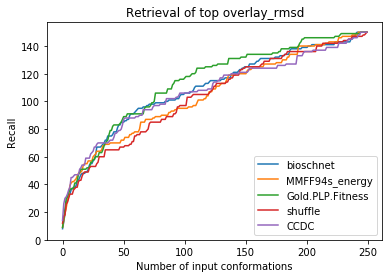

first_successful_pose
bioschnet
MMFF94s_energy
Gold.PLP.Fitness
shuffle
CCDC


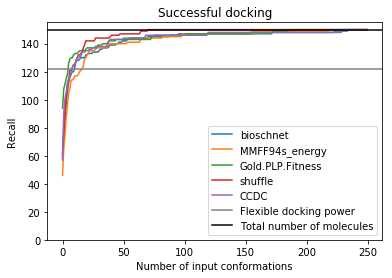

correct_conf
bioschnet
MMFF94s_energy
Gold.PLP.Fitness
shuffle
CCDC


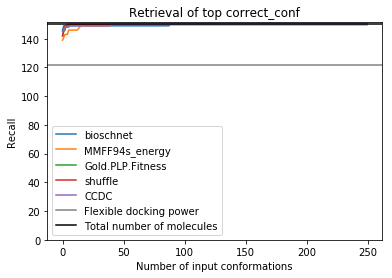

In [60]:
pdbbind_analysis_for_uniprot('P00918') #CA2

Loading results


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 66/66 [00:00<00:00, 1952.74it/s]

Compiling metrics
Flexible n_mols
30
Flexible docking power top score
0.8333333333333334
Flexible docking power top pose
0.9333333333333333
Flexible generation power
0.8
Rigid n_mols
30
Rigid docking power top score
0.9
Rigid docking power top pose
1.0
Rigid generation power
0.8


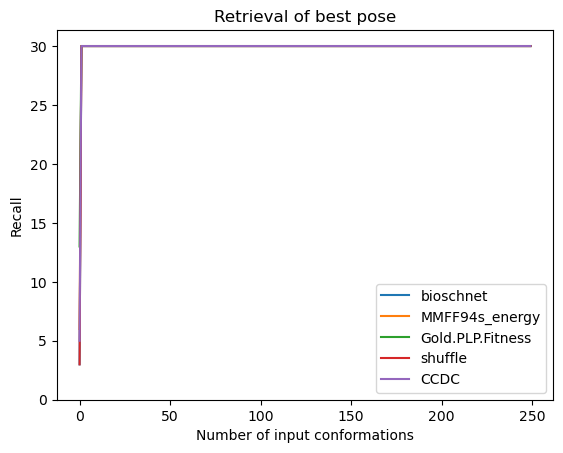

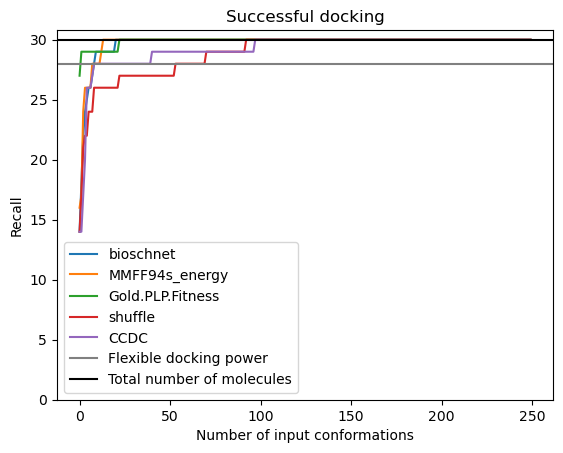

In [20]:
pdbbind_analysis_for_uniprot('O60674') # JAK2

  0%|                                                   | 0/193 [00:00<?, ?it/s]

Loading results


100%|███████████████████████████████████████| 73/73 [00:00<00:00, 107925.34it/s]


Compiling metrics
Flexible n_mols
71
Flexible docking power top score
0.352112676056338
Flexible docking power top pose
0.5070422535211268
Flexible generation power
0.647887323943662
Rigid generation power
0.7746478873239436
score
bioschnet
MMFF94s_energy
Gold.PLP.Fitness
shuffle
CCDC


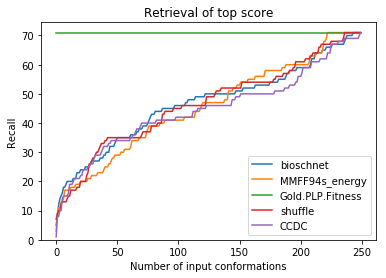

ligand_rmsd
bioschnet
MMFF94s_energy
Gold.PLP.Fitness
shuffle
CCDC


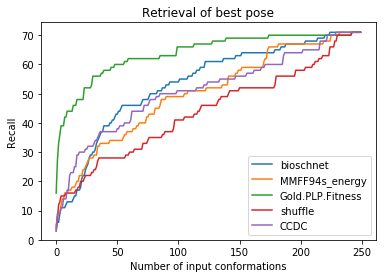

overlay_rmsd
bioschnet
MMFF94s_energy
Gold.PLP.Fitness
shuffle
CCDC


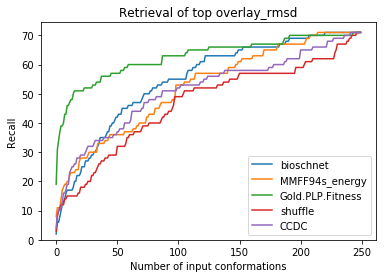

first_successful_pose
bioschnet
MMFF94s_energy
Gold.PLP.Fitness
shuffle
CCDC


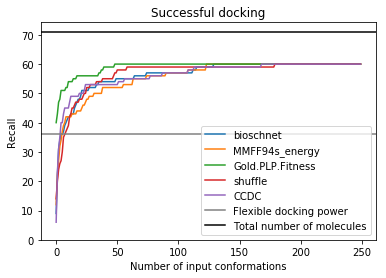

correct_conf
bioschnet
MMFF94s_energy
Gold.PLP.Fitness
shuffle
CCDC


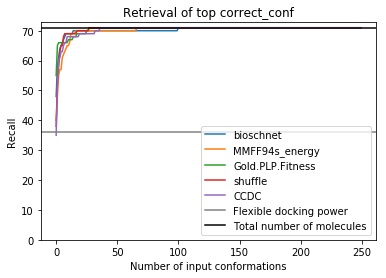

In [64]:
pdbbind_analysis_for_uniprot('O60885', only_good_docking=False) #Bromodomain protein 2/4

  5%|██▎                                        | 6/111 [00:00<00:02, 36.82it/s]

Loading results


100%|████████████████████████████████████████| 40/40 [00:00<00:00, 86213.85it/s]

Compiling metrics
Flexible n_mols
32
Flexible docking power top score
0.65625
Flexible docking power top pose
0.78125
Flexible generation power
0.71875
Rigid generation power
0.6875
score
bioschnet
MMFF94s_energy
Gold.PLP.Fitness
shuffle
CCDC


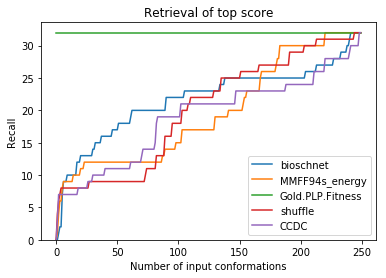

ligand_rmsd
bioschnet
MMFF94s_energy
Gold.PLP.Fitness
shuffle
CCDC


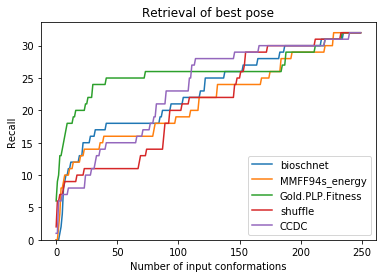

overlay_rmsd
bioschnet
MMFF94s_energy
Gold.PLP.Fitness
shuffle
CCDC


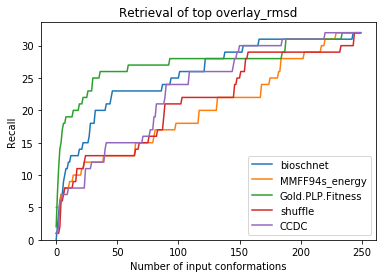

first_successful_pose
bioschnet
MMFF94s_energy
Gold.PLP.Fitness
shuffle
CCDC


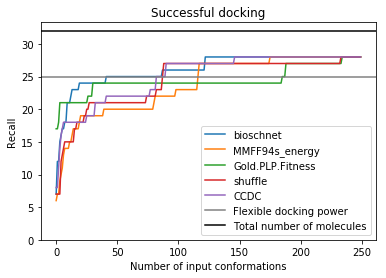

correct_conf
bioschnet
MMFF94s_energy
Gold.PLP.Fitness
shuffle
CCDC


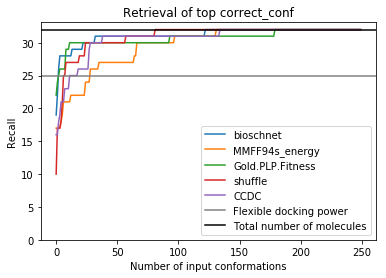

In [63]:
pdbbind_analysis_for_uniprot('P03366', only_good_docking=False) #HIV protease